# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


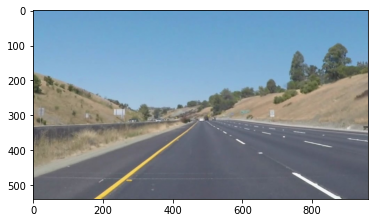

In [3]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')



## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    x_r = [];
    y_r = [];
    x_l = [];
    y_l = [];
    y_max = img.shape[0];
    y_min = 0;
    x_max = img.shape[1];
    x_min = 0;
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0 and slope <1:
                x_r = x_r + [x1,x2]
                y_r = y_r + [y1,y2]
            elif slope < -0.6 and slope >-1:
                x_l = x_l + [x1,x2]
                y_l = y_l + [y1,y2]
    
    if len(x_r) == 0 | len(y_r) == 0:
        print('No right lane found')
    else:
        fit_r = np.polyfit(x_r,y_r,deg=1)
        print('fit_r is',fit_r)
        print('y_max-fit_r[1])/fit_r[0]',(y_max-fit_r[1])/fit_r[0])
        print('y_min-fit_r[1])/fit_r[0]',(y_min-fit_r[1])/fit_r[0])
        cv2.line(img, (math.ceil((y_max-fit_r[1])/fit_r[0]), y_max), \
                      (math.ceil((y_min-fit_r[1])/fit_r[0]), y_min), color, thickness)
    
    if len(x_l) == 0 | len(y_l) == 0:
        print('No left lane found')
    else:
        fit_l = np.polyfit(x_l,y_l,deg=1)
        cv2.line(img, (math.ceil((y_max-fit_l[1])/fit_l[0]), y_max),\
                      (math.ceil((y_min-fit_l[1])/fit_l[0]), y_min), color, thickness)
        
        
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Region Masking

vertices is [[[100 539]
  [900 539]
  [600 320]
  [400 320]]]
(540, 960, 3)


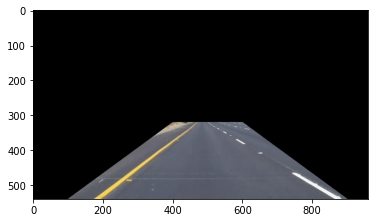

In [5]:
# Define the vertices of the region of masking

left_bottom = [100, 539]
right_bottom = [900, 539]
left_upper = [400, 320]
right_upper = [600,320]
vertices = np.array([[left_bottom, right_bottom,right_upper, left_upper]],dtype=np.int32)
print('vertices is',vertices)

color_mask = region_of_interest(image, vertices)

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(color_mask)  
print(color_mask.shape)

## Generate Gray Scale Image

This image below is after gray scale


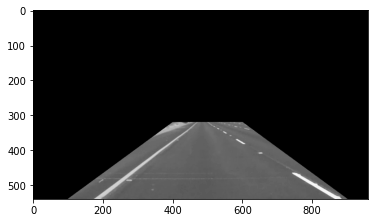

In [6]:
#printing the greyscale image
gray = grayscale(color_mask)
print('This image below is after gray scale')
plt.imshow(gray,cmap='gray')

## Detect Edge

This image below is after gaussian blur


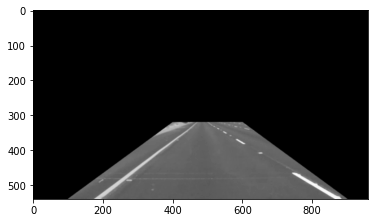

In [7]:
# Define a kernel size for Gaussian smoothing / blurring.
kernel_size = 3 # any ODD number. LARGER kernel size = average, or smooth, over a LARGER area
blur_gray = gaussian_blur(gray, kernel_size)
print('This image below is after gaussian blur')
plt.imshow(blur_gray,cmap='gray')

This image below is after canny edge detection


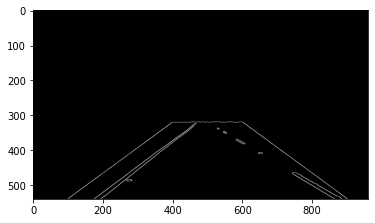

In [8]:
# Run Canny edge detection
low_threshold = 150
high_threshold = 300
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
print('This image below is after canny edge detection')
plt.imshow(edges,cmap='gray')

## Color Select

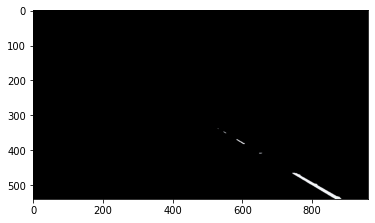

In [9]:
# Define our color selection criteria

red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]
color_select = np.copy(image)

# Identify pixels below the threshold, and these that do NOT (below the threshold) will be blacked out.
thresholds = (color_mask[:,:,0] < rgb_threshold[0]) \
            | (color_mask[:,:,1] < rgb_threshold[1]) \
            | (color_mask[:,:,2] < rgb_threshold[2]) 
# color_select[thresholds] = [0,0,0] --> black & color_select[thresholds] = [250,250,250] --> white
color_select[thresholds] = [0,0,0]

plt.imshow(color_select)

## Hough Transform - Lane Finding

fit_r is [0.60847473 2.22464496]
y_max-fit_r[1])/fit_r[0] 883.8088542486483
y_min-fit_r[1])/fit_r[0] -3.6561008174011844
vertices_offset is [[[110 549]
  [910 549]
  [610 330]
  [410 330]]]
This image below is after canny Hough transform


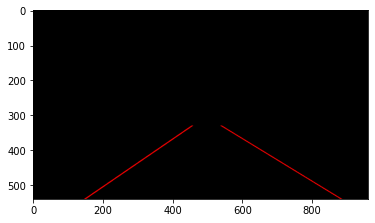

In [10]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # rho: distance resolution. UNIT = pixel
theta = np.pi/180 # theta: angular resolution. UNIT = radian
threshold = 15 # the minimum number of votes (intersections in a given grid cell)
min_line_len = 8 # the minimum length of a line (in PIXELS) that you will accept in the output
max_line_gap = 10 # the maximum distance (again, in PIXELS) between segments that you will allow to be connected into a single line. 
line_image = np.copy(image)*0 #creating a blank to draw lines on

line_image = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)
# for x1,y1,x2,y2 in line_image[0]:
#     print('x1,y1,x2,y2',x1,y1,x2,y2)
    #cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

# Remove the line from the Mask
offset = -10
vertices_offset = np.array([[[i-offset for i in left_bottom], \
                      [i-offset for i in right_bottom],\
                      [i-offset for i in right_upper],\
                      [i-offset for i in left_upper]]],dtype=np.int32)
print('vertices_offset is',vertices_offset)

line_image = region_of_interest(line_image, vertices_offset)

    
print('This image below is after canny Hough transform')
#plt.imshow(edges,cmap='gray')
plt.imshow(line_image)



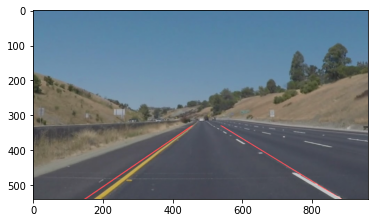

In [11]:
plt.imshow(weighted_img(line_image, image, α=0.8, β=1., γ=0.))

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

Output images will be saved to /test_images_output
process solidYellowCurve.jpg ...
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
fit_r is [ 0.57379835 32.77512969]
y_max-fit_r[1])/fit_r[0] 883.977567820463
y_min-fit_r[1])/fit_r[0] -57.11959551306605
process solidYellowLeft.jpg ...
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
fit_r is [ 0.57548193 28.81581994]
y_max-fit_r[1])/fit_r[0] 888.2714743315976
y_min-fit_r[1])/fit_r[0] -50.07250196633418
process solidYellowCurve2.jpg ...
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
fit_r is [ 0.59388086 14.50761725]
y_max-fit_r[1])/fit_r[0] 884.8447800205067
y_min-fit_r[1])/fit_r[0] -24.42849757222217
process solidWhiteRight.jpg ...
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
fit_r is [  0.63883837 -14.92814124]
y_max-fit_r[1])/fit_r[0] 868.651859349174
y_min-fit_r[1])/fit_r[0] 23.367633901079483
process whiteCarLaneSwitch.jpg ...
This image is: 

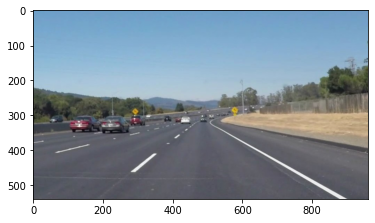

In [13]:
import os
import shutil

# Create output directory
if os.path.exists("test_images_output/"):
    print('Output images will be saved to /test_images_output')
else: 
    print('Directory will be created: /test_images_output')
    os.makedirs("test_images_output/")

directory = os.listdir("test_images/")
    

for filename in directory:
    
    # Copy image to Output Folder
    shutil.copy('test_images/%s'%(filename),'test_images_output/%s'%(filename))
    
    # reading in an image
    image = mpimg.imread('test_images/%s'%(filename))
    print('process %s ...'%(filename))

    # printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image) 
    
    ## Musk: Define the vertices of the region of masking
    color_mask = region_of_interest(image, vertices)
    
    #printing the greyscale image
    gray = grayscale(color_mask)
    
    # Define a kernel size for Gaussian smoothing / blurring.
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Run Canny edge detection
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Color Select
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)
    # Identify pixels below the threshold, and these that do NOT (below the threshold) will be blacked out.
    thresholds = (color_mask[:,:,0] < rgb_threshold[0]) \
                | (color_mask[:,:,1] < rgb_threshold[1]) \
                | (color_mask[:,:,2] < rgb_threshold[2]) 
    color_select[thresholds] = [0,0,0]
    
    # Hough Transform - Lane Finding
    line_image = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Remove the line from the Mask
    offset = -10
    vertices_offset = np.array([[[i-offset for i in left_bottom], \
                          [i-offset for i in right_bottom],\
                          [i-offset for i in right_upper],\
                          [i-offset for i in left_upper]]],dtype=np.int32)

    line_image = region_of_interest(line_image, vertices_offset)
    
    # Output the image
    image_out = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    cv2.imwrite(os.path.join('test_images_output/%s_out.jpg'%(filename)),image_out)

    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # printing out some stats and plotting
    # print('This image is:', type(image), 'with dimensions:', image.shape)
    # plt.imshow(image) 
    
    ## Musk: Define the vertices of the region of masking
    color_mask = region_of_interest(image, vertices)
    
    #printing the greyscale image
    gray = grayscale(color_mask)
    
    # Define a kernel size for Gaussian smoothing / blurring.
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Run Canny edge detection
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Color Select
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    color_select = np.copy(image)
    # Identify pixels below the threshold, and these that do NOT (below the threshold) will be blacked out.
    thresholds = (color_mask[:,:,0] < rgb_threshold[0]) \
                | (color_mask[:,:,1] < rgb_threshold[1]) \
                | (color_mask[:,:,2] < rgb_threshold[2]) 
    color_select[thresholds] = [0,0,0]
    
    # Hough Transform - Lane Finding
    line_image = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Remove the line from the Mask
    offset = -10
    vertices_offset = np.array([[[i-offset for i in left_bottom], \
                          [i-offset for i in right_bottom],\
                          [i-offset for i in right_upper],\
                          [i-offset for i in left_upper]]],dtype=np.int32)

    line_image = region_of_interest(line_image, vertices_offset)
    
    # Output the image
    image_out = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return image_out

Let's try the one with the solid white lane on the right first ...

In [16]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 4/681 [00:00<00:22, 30.50it/s, now=None]

fit_r is [ 0.59286413 20.06224653]
y_max-fit_r[1])/fit_r[0] 876.9931101495299
y_min-fit_r[1])/fit_r[0] -33.83953534166474
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

fit_r is [ 0.59286413 20.06224653]
y_max-fit_r[1])/fit_r[0] 876.9931101495299
y_min-fit_r[1])/fit_r[0] -33.83953534166474
fit_r is [ 0.59833493 20.61338592]
y_max-fit_r[1])/fit_r[0] 868.0533115622532
y_min-fit_r[1])/fit_r[0] -34.45124965473379
fit_r is [ 0.59719447 21.34388686]
y_max-fit_r[1])/fit_r[0] 868.4878061658804
y_min-fit_r[1])/fit_r[0] -35.740262197982176
fit_r is [  0.65185927 -13.99816625]
y_max-fit_r[1])/fit_r[0] 849.8738808197076
y_min-fit_r[1])/fit_r[0] 21.47421526051997


t:   1%|▏         | 10/681 [00:00<00:25, 26.18it/s, now=None]

fit_r is [  0.64369237 -13.47727322]
y_max-fit_r[1])/fit_r[0] 859.847495082131
y_min-fit_r[1])/fit_r[0] 20.937444367898387
fit_r is [ 0.51498148 65.81612399]
y_max-fit_r[1])/fit_r[0] 920.7785038857411
y_min-fit_r[1])/fit_r[0] -127.8028951277371
fit_r is [ 0.527838   54.21241946]
y_max-fit_r[1])/fit_r[0] 920.3346074563073
y_min-fit_r[1])/fit_r[0] -102.70654866295935
fit_r is [ 0.57267393 30.28283646]
y_max-fit_r[1])/fit_r[0] 890.0652477852369
y_min-fit_r[1])/fit_r[0] -52.87971891521035
fit_r is [ 0.59480578 15.79504249]
y_max-fit_r[1])/fit_r[0] 881.30441400443
y_min-fit_r[1])/fit_r[0] -26.554958075618977


t:   2%|▏         | 17/681 [00:00<00:23, 28.10it/s, now=None]

fit_r is [  0.6499126  -15.50363017]
y_max-fit_r[1])/fit_r[0] 854.735893604673
y_min-fit_r[1])/fit_r[0] 23.85494615631543
fit_r is [ 0.58741229 15.38180484]
y_max-fit_r[1])/fit_r[0] 893.10047464177
y_min-fit_r[1])/fit_r[0] -26.18570481467078
fit_r is [ 0.59179194 13.9000355 ]
y_max-fit_r[1])/fit_r[0] 888.9948096520898
y_min-fit_r[1])/fit_r[0] -23.488044566797324
fit_r is [0.60858977 5.71671368]
y_max-fit_r[1])/fit_r[0] 877.9038244531091
y_min-fit_r[1])/fit_r[0] -9.393377876490757
fit_r is [  0.64443847 -17.23019544]
y_max-fit_r[1])/fit_r[0] 864.6755545646294
y_min-fit_r[1])/fit_r[0] 26.73675784045791
fit_r is [  0.67006853 -34.28990188]
y_max-fit_r[1])/fit_r[0] 857.0614410309091
y_min-fit_r[1])/fit_r[0] 51.17372362634835
fit_r is [ 0.62024787 -0.61334481]
y_max-fit_r[1])/fit_r[0] 871.6085492126247
y_min-fit_r[1])/fit_r[0] 0.9888704831140775


t:   3%|▎         | 20/681 [00:00<00:25, 25.74it/s, now=None]

fit_r is [0.6066289  7.57976079]
y_max-fit_r[1])/fit_r[0] 877.6704098527517
y_min-fit_r[1])/fit_r[0] -12.494888935159977
fit_r is [ 0.55813284 35.18376991]
y_max-fit_r[1])/fit_r[0] 904.4732680871838
y_min-fit_r[1])/fit_r[0] -63.03834435768905
fit_r is [ 0.5348924  48.84973961]
y_max-fit_r[1])/fit_r[0] 918.2225512643286
y_min-fit_r[1])/fit_r[0] -91.32629289723505
fit_r is [ 0.54328161 40.10473821]
y_max-fit_r[1])/fit_r[0] 920.1402271755032
y_min-fit_r[1])/fit_r[0] -73.81942927913504
fit_r is [ 0.5758006  23.27124503]
y_max-fit_r[1])/fit_r[0] 897.4091990620773
y_min-fit_r[1])/fit_r[0] -40.4154581387157


t:   4%|▍         | 26/681 [00:01<00:28, 23.33it/s, now=None]

fit_r is [ 0.56907487 33.5178089 ]
y_max-fit_r[1])/fit_r[0] 890.0097610252313
y_min-fit_r[1])/fit_r[0] -58.898768036798764
fit_r is [ 0.54122076 48.241922  ]
y_max-fit_r[1])/fit_r[0] 908.6090434174022
y_min-fit_r[1])/fit_r[0] -89.13538702155697
fit_r is [ 0.58777793 17.58152946]
y_max-fit_r[1])/fit_r[0] 888.802466084796
y_min-fit_r[1])/fit_r[0] -29.9118572978004
fit_r is [ 0.60116987 11.19463969]
y_max-fit_r[1])/fit_r[0] 879.6271840355305
y_min-fit_r[1])/fit_r[0] -18.621425059752095
fit_r is [  0.63434576 -12.57860427]
y_max-fit_r[1])/fit_r[0] 871.1000214985785
y_min-fit_r[1])/fit_r[0] 19.829255722072165
fit_r is [ 0.62233883 -5.19971803]
y_max-fit_r[1])/fit_r[0] 876.0496515556171
y_min-fit_r[1])/fit_r[0] 8.355123852329818


t:   5%|▍         | 33/681 [00:01<00:24, 26.21it/s, now=None]

fit_r is [ 0.57851882 29.66884175]
y_max-fit_r[1])/fit_r[0] 882.1340681423019
y_min-fit_r[1])/fit_r[0] -51.28414295131337
fit_r is [ 0.61884414 -6.97247457]
y_max-fit_r[1])/fit_r[0] 883.8614419131534
y_min-fit_r[1])/fit_r[0] 11.266931542652125
fit_r is [ 0.61412976 -1.94574755]
y_max-fit_r[1])/fit_r[0] 882.4613044020169
y_min-fit_r[1])/fit_r[0] 3.1683003791623983
fit_r is [ 0.56481807 26.87792703]
y_max-fit_r[1])/fit_r[0] 908.4731876737388
y_min-fit_r[1])/fit_r[0] -47.58687519661728
fit_r is [ 0.6049945  -3.13884751]
y_max-fit_r[1])/fit_r[0] 897.7583195575103
y_min-fit_r[1])/fit_r[0] 5.188224850585034
fit_r is [ 0.50173621 68.41944375]
y_max-fit_r[1])/fit_r[0] 939.8973871267888
y_min-fit_r[1])/fit_r[0] -136.3653686695739


t:   6%|▌         | 39/681 [00:01<00:23, 27.71it/s, now=None]

fit_r is [ 0.52936139 53.74199997]
y_max-fit_r[1])/fit_r[0] 918.5747323036001
y_min-fit_r[1])/fit_r[0] -101.52232607265859
fit_r is [ 0.62404505 -8.80686403]
y_max-fit_r[1])/fit_r[0] 879.4346878681138
y_min-fit_r[1])/fit_r[0] 14.112545282770952
fit_r is [ 0.58396723 13.75280051]
y_max-fit_r[1])/fit_r[0] 901.1587782355257
y_min-fit_r[1])/fit_r[0] -23.5506372586068
fit_r is [0.59836172 5.48768905]
y_max-fit_r[1])/fit_r[0] 893.2929633137751
y_min-fit_r[1])/fit_r[0] -9.171190100697247
fit_r is [0.59711245 7.29789033]
y_max-fit_r[1])/fit_r[0] 892.130299027351
y_min-fit_r[1])/fit_r[0] -12.22196977950478
fit_r is [ 0.61008162 -0.66443386]
y_max-fit_r[1])/fit_r[0] 886.2165591352119
y_min-fit_r[1])/fit_r[0] 1.0890901047797157
fit_r is [  0.62089019 -10.8233958 ]
y_max-fit_r[1])/fit_r[0] 887.1510653863147
y_min-fit_r[1])/fit_r[0] 17.432061136446944


t:   7%|▋         | 46/681 [00:01<00:22, 28.40it/s, now=None]

fit_r is [ 0.61360496 -3.28507949]
y_max-fit_r[1])/fit_r[0] 885.398781494627
y_min-fit_r[1])/fit_r[0] 5.353736902491563
fit_r is [0.60738207 1.3645326 ]
y_max-fit_r[1])/fit_r[0] 886.814890730143
y_min-fit_r[1])/fit_r[0] -2.2465802928688356
fit_r is [ 0.52270638 61.73152661]
y_max-fit_r[1])/fit_r[0] 914.984958201169
y_min-fit_r[1])/fit_r[0] -118.09981513345804
fit_r is [ 0.54500849 37.91389033]
y_max-fit_r[1])/fit_r[0] 921.2445646021097
y_min-fit_r[1])/fit_r[0] -69.5656874664672
fit_r is [ 0.55912596 32.98554064]
y_max-fit_r[1])/fit_r[0] 906.7982766177387
y_min-fit_r[1])/fit_r[0] -58.994829157095964
fit_r is [ 0.55850443 33.4911657 ]
y_max-fit_r[1])/fit_r[0] 906.9020854655807
y_min-fit_r[1])/fit_r[0] -59.965801114052816


t:   8%|▊         | 52/681 [00:01<00:23, 26.46it/s, now=None]

fit_r is [ 0.58495394 19.63359202]
y_max-fit_r[1])/fit_r[0] 889.5852717370483
y_min-fit_r[1])/fit_r[0] -33.56433855423576
fit_r is [ 0.56734217 28.40632865]
y_max-fit_r[1])/fit_r[0] 901.737430269103
y_min-fit_r[1])/fit_r[0] -50.06912953151098
fit_r is [ 0.5789309  18.82190601]
y_max-fit_r[1])/fit_r[0] 900.2423116853417
y_min-fit_r[1])/fit_r[0] -32.511489587841325
fit_r is [ 0.61097411 -2.72623636]
y_max-fit_r[1])/fit_r[0] 888.2966238584738
y_min-fit_r[1])/fit_r[0] 4.462114405152258
fit_r is [0.60491932 5.07066321]
y_max-fit_r[1])/fit_r[0] 884.2986516853936
y_min-fit_r[1])/fit_r[0] -8.382379378717747


t:   8%|▊         | 55/681 [00:02<00:25, 24.54it/s, now=None]

fit_r is [0.60470872 5.70780329]
y_max-fit_r[1])/fit_r[0] 883.5529812727666
y_min-fit_r[1])/fit_r[0] -9.438929946274136
fit_r is [0.61077917 3.70248013]
y_max-fit_r[1])/fit_r[0] 878.0546951862959
y_min-fit_r[1])/fit_r[0] -6.061896501793302
fit_r is [0.6106235  2.38013241]
y_max-fit_r[1])/fit_r[0] 880.4441185995566
y_min-fit_r[1])/fit_r[0] -3.8978722877631014
fit_r is [ 0.59876203 12.26975561]
y_max-fit_r[1])/fit_r[0] 881.3689230185693
y_min-fit_r[1])/fit_r[0] -20.491873261771712


t:   9%|▊         | 58/681 [00:02<00:30, 20.51it/s, now=None]

fit_r is [ 0.55261891 38.22173932]
y_max-fit_r[1])/fit_r[0] 908.0005272970154
y_min-fit_r[1])/fit_r[0] -69.16473305446179
fit_r is [ 0.53635734 46.563767  ]
y_max-fit_r[1])/fit_r[0] 919.9766492689993
y_min-fit_r[1])/fit_r[0] -86.81482119537657
fit_r is [ 0.55865481 35.5547875 ]
y_max-fit_r[1])/fit_r[0] 902.9640493137865
y_min-fit_r[1])/fit_r[0] -63.643571393684866
fit_r is [ 0.53615792 55.32788731]
y_max-fit_r[1])/fit_r[0] 903.9726752432841
y_min-fit_r[1])/fit_r[0] -103.19326611268902


t:   9%|▉         | 64/681 [00:02<00:31, 19.73it/s, now=None]

fit_r is [0.61218007 3.32785381]
y_max-fit_r[1])/fit_r[0] 876.6573321893524
y_min-fit_r[1])/fit_r[0] -5.436070164411803
fit_r is [ 0.57127281 29.35509396]
y_max-fit_r[1])/fit_r[0] 893.8722358465675
y_min-fit_r[1])/fit_r[0] -51.385420992287514
fit_r is [ 0.58964807 19.77659591]
y_max-fit_r[1])/fit_r[0] 882.2608424906382
y_min-fit_r[1])/fit_r[0] -33.53966013953254
fit_r is [ 0.58742018 18.09665762]
y_max-fit_r[1])/fit_r[0] 888.4668240370495
y_min-fit_r[1])/fit_r[0] -30.807007001652334
fit_r is [ 0.59873294 10.11393701]
y_max-fit_r[1])/fit_r[0] 885.0123796555048
y_min-fit_r[1])/fit_r[0] -16.89223416483482


t:  10%|█         | 70/681 [00:02<00:29, 20.86it/s, now=None]

fit_r is [0.60791066 4.58678712]
y_max-fit_r[1])/fit_r[0] 880.7432518421276
y_min-fit_r[1])/fit_r[0] -7.545166431148545
fit_r is [ 0.59404621 16.9676203 ]
y_max-fit_r[1])/fit_r[0] 880.4573960929728
y_min-fit_r[1])/fit_r[0] -28.562795285318263
fit_r is [ 0.62270522 -5.89038683]
y_max-fit_r[1])/fit_r[0] 876.6433376931818
y_min-fit_r[1])/fit_r[0] 9.459350256460402
fit_r is [ 0.59577817 11.61758353]
y_max-fit_r[1])/fit_r[0] 886.8777721397305
y_min-fit_r[1])/fit_r[0] -19.49984759727777
fit_r is [ 0.53607569 46.5060444 ]
y_max-fit_r[1])/fit_r[0] 920.5676770610235
y_min-fit_r[1])/fit_r[0] -86.75275710603707


t:  11%|█         | 73/681 [00:03<00:29, 20.54it/s, now=None]

fit_r is [ 0.48905469 82.37531133]
y_max-fit_r[1])/fit_r[0] 935.7331551585222
y_min-fit_r[1])/fit_r[0] -168.4378310022983
fit_r is [ 0.55329753 38.63082702]
y_max-fit_r[1])/fit_r[0] 906.1474913970613
y_min-fit_r[1])/fit_r[0] -69.81926468355368
fit_r is [ 0.53794102 49.17201897]
y_max-fit_r[1])/fit_r[0] 912.4197010888709
y_min-fit_r[1])/fit_r[0] -91.40782634418449
fit_r is [ 0.5453783  44.71438119]
y_max-fit_r[1])/fit_r[0] 908.1505794676661
y_min-fit_r[1])/fit_r[0] -81.98782610656004
fit_r is [ 0.57401043 26.5808265 ]
y_max-fit_r[1])/fit_r[0] 894.4422313036614
y_min-fit_r[1])/fit_r[0] -46.307218339020174


t:  12%|█▏        | 79/681 [00:03<00:30, 19.54it/s, now=None]

fit_r is [ 0.5787906  23.59243409]
y_max-fit_r[1])/fit_r[0] 892.2182987137998
y_min-fit_r[1])/fit_r[0] -40.76160535241314
fit_r is [0.60949977 6.10338364]
y_max-fit_r[1])/fit_r[0] 875.9586792330651
y_min-fit_r[1])/fit_r[0] -10.013758675700974
fit_r is [ 0.62078321 -1.3001789 ]
y_max-fit_r[1])/fit_r[0] 871.9633051478967
y_min-fit_r[1])/fit_r[0] 2.094416996039798
fit_r is [0.61841264 5.37442644]
y_max-fit_r[1])/fit_r[0] 864.5126934430995
y_min-fit_r[1])/fit_r[0] -8.690680184399


t:  12%|█▏        | 83/681 [00:03<00:32, 18.43it/s, now=None]

fit_r is [  0.64420128 -13.07850116]
y_max-fit_r[1])/fit_r[0] 858.5492174100143
y_min-fit_r[1])/fit_r[0] 20.301886455686006
fit_r is [ 0.58606291 26.53238207]
y_max-fit_r[1])/fit_r[0] 876.1305405648387
y_min-fit_r[1])/fit_r[0] -45.27224197850296
fit_r is [ 0.5209808 56.841288 ]
y_max-fit_r[1])/fit_r[0] 927.4021429728983
y_min-fit_r[1])/fit_r[0] -109.10438122098584
fit_r is [ 0.52496947 54.45006279]
y_max-fit_r[1])/fit_r[0] 924.9108122627208
y_min-fit_r[1])/fit_r[0] -103.720437267331


t:  13%|█▎        | 89/681 [00:03<00:28, 20.82it/s, now=None]

fit_r is [ 0.56878126 33.4225924 ]
y_max-fit_r[1])/fit_r[0] 890.6365980283608
y_min-fit_r[1])/fit_r[0] -58.76176778532372
fit_r is [ 0.53209117 55.09905572]
y_max-fit_r[1])/fit_r[0] 911.3117597354099
y_min-fit_r[1])/fit_r[0] -103.55190687114789
fit_r is [ 0.62285552 -1.92960185]
y_max-fit_r[1])/fit_r[0] 870.0727222223016
y_min-fit_r[1])/fit_r[0] 3.097992674362845
fit_r is [ 0.52397405 61.42845301]
y_max-fit_r[1])/fit_r[0] 913.349715165563
y_min-fit_r[1])/fit_r[0] -117.23567857591468
fit_r is [ 0.57930892 25.65314185]
y_max-fit_r[1])/fit_r[0] 887.8628379381064
y_min-fit_r[1])/fit_r[0] -44.2823183757833
fit_r is [ 0.57235809 29.83872177]
y_max-fit_r[1])/fit_r[0] 891.3323419282987
y_min-fit_r[1])/fit_r[0] -52.1329604819665


t:  14%|█▎        | 92/681 [00:03<00:27, 21.44it/s, now=None]

fit_r is [ 0.59454777 16.87530599]
y_max-fit_r[1])/fit_r[0] 879.8699086053108
y_min-fit_r[1])/fit_r[0] -28.383431547977658
fit_r is [ 0.62762964 -2.193815  ]
y_max-fit_r[1])/fit_r[0] 863.875416074211
y_min-fit_r[1])/fit_r[0] 3.4953973934316616
fit_r is [ 0.59926539 16.64169078]
y_max-fit_r[1])/fit_r[0] 873.3331164966648
y_min-fit_r[1])/fit_r[0] -27.7701517609964
fit_r is [0.62274667 5.6959295 ]
y_max-fit_r[1])/fit_r[0] 857.9798110511693
y_min-fit_r[1])/fit_r[0] -9.146463196494585
fit_r is [ 0.63647667 -5.82044699]
y_max-fit_r[1])/fit_r[0] 857.5655202406516
y_min-fit_r[1])/fit_r[0] 9.144792357591085


t:  14%|█▍        | 97/681 [00:04<00:32, 18.09it/s, now=None]

fit_r is [ 0.51311731 65.42819795]
y_max-fit_r[1])/fit_r[0] 924.8797292191771
y_min-fit_r[1])/fit_r[0] -127.51118743520118
fit_r is [ 0.51921283 62.85693223]
y_max-fit_r[1])/fit_r[0] 918.9739562563266
y_min-fit_r[1])/fit_r[0] -121.06197823771957
fit_r is [ 0.57267693 36.31088386]
y_max-fit_r[1])/fit_r[0] 879.5344964562121
y_min-fit_r[1])/fit_r[0] -63.405529182407044


t:  15%|█▍        | 99/681 [00:04<00:41, 14.05it/s, now=None]

fit_r is [ 0.5356788  49.53680678]
y_max-fit_r[1])/fit_r[0] 915.5919431779116
y_min-fit_r[1])/fit_r[0] -92.47483155144363
fit_r is [ 0.59817325 19.80823296]
y_max-fit_r[1])/fit_r[0] 869.6339486598686
y_min-fit_r[1])/fit_r[0] -33.11454146723922


t:  15%|█▍        | 101/681 [00:04<00:49, 11.70it/s, now=None]

fit_r is [ 0.54532329 47.18574067]
y_max-fit_r[1])/fit_r[0] 903.7102786813213
y_min-fit_r[1])/fit_r[0] -86.52801343218434
fit_r is [ 0.5693635  34.46024862]
y_max-fit_r[1])/fit_r[0] 887.9033305529559
y_min-fit_r[1])/fit_r[0] -60.52416142136796
fit_r is [ 0.55875892 39.18406246]
y_max-fit_r[1])/fit_r[0] 896.3005704398568
y_min-fit_r[1])/fit_r[0] -70.1269566316395


t:  15%|█▌        | 105/681 [00:05<00:40, 14.06it/s, now=None]

fit_r is [ 0.58545983 22.78916392]
y_max-fit_r[1])/fit_r[0] 883.4266770700647
y_min-fit_r[1])/fit_r[0] -38.92523889331499
fit_r is [ 0.63801965 -6.71236375]
y_max-fit_r[1])/fit_r[0] 856.8895338372733
y_min-fit_r[1])/fit_r[0] 10.5206222313421
fit_r is [ 0.62729868 -2.97010462]
y_max-fit_r[1])/fit_r[0] 865.5687044063111
y_min-fit_r[1])/fit_r[0] 4.734753501494163
fit_r is [0.62065374 3.56389857]
y_max-fit_r[1])/fit_r[0] 864.308181465451
y_min-fit_r[1])/fit_r[0] -5.742168885049238


t:  16%|█▌        | 109/681 [00:05<00:38, 15.03it/s, now=None]

fit_r is [ 0.59426551 18.12507316]
y_max-fit_r[1])/fit_r[0] 878.1847770376068
y_min-fit_r[1])/fit_r[0] -30.49995796852621
fit_r is [ 0.52237337 56.05697232]
y_max-fit_r[1])/fit_r[0] 926.4312799212274
y_min-fit_r[1])/fit_r[0] -107.31207940514038
fit_r is [ 0.52240751 57.81338485]
y_max-fit_r[1])/fit_r[0] 923.0085774299708
y_min-fit_r[1])/fit_r[0] -110.66721561445758
fit_r is [ 0.52460823 65.01582914]
y_max-fit_r[1])/fit_r[0] 905.4073990897292
y_min-fit_r[1])/fit_r[0] -123.93215684763422


t:  16%|█▋        | 112/681 [00:05<00:34, 16.38it/s, now=None]

fit_r is [ 0.57656988 30.97814366]
y_max-fit_r[1])/fit_r[0] 882.8450406876218
y_min-fit_r[1])/fit_r[0] -53.72834223751388
fit_r is [0.61888866 3.66411208]
y_max-fit_r[1])/fit_r[0] 866.6112649146978
y_min-fit_r[1])/fit_r[0] -5.9204705040014804
fit_r is [ 0.55819501 40.64247289]
y_max-fit_r[1])/fit_r[0] 894.593319938118
y_min-fit_r[1])/fit_r[0] -72.81052708923916
fit_r is [ 0.56291969 37.5229058 ]
y_max-fit_r[1])/fit_r[0] 892.6266151454975
y_min-fit_r[1])/fit_r[0] -66.65765420730408


t:  17%|█▋        | 116/681 [00:05<00:37, 15.11it/s, now=None]

fit_r is [ 0.58569023 22.1469281 ]
y_max-fit_r[1])/fit_r[0] 884.1757048727903
y_min-fit_r[1])/fit_r[0] -37.81338148332887
fit_r is [ 0.59784668 19.41354669]
y_max-fit_r[1])/fit_r[0] 870.7691596283756
y_min-fit_r[1])/fit_r[0] -32.47245030268452
fit_r is [ 0.60235177 12.7898737 ]
y_max-fit_r[1])/fit_r[0] 875.2528875717717
y_min-fit_r[1])/fit_r[0] -21.233230029326617
fit_r is 

t:  18%|█▊        | 120/681 [00:05<00:35, 15.82it/s, now=None]

[ 0.59757945 19.76213675]
y_max-fit_r[1])/fit_r[0] 870.5752303391303
y_min-fit_r[1])/fit_r[0] -33.070308731855796
fit_r is [0.62353661 2.06757626]
y_max-fit_r[1])/fit_r[0] 862.7118472417743
y_min-fit_r[1])/fit_r[0] -3.315885898548267
fit_r is [ 0.60472193 13.68350775]
y_max-fit_r[1])/fit_r[0] 870.3446361482193
y_min-fit_r[1])/fit_r[0] -22.627768168777514
fit_r is [ 0.56266609 36.61692274]
y_max-fit_r[1])/fit_r[0] 894.6390858323849
y_min-fit_r[1])/fit_r[0] -65.07753590138823


t:  18%|█▊        | 124/681 [00:06<00:33, 16.60it/s, now=None]

fit_r is [ 0.55740703 39.38477277]
y_max-fit_r[1])/fit_r[0] 898.1143058793544
y_min-fit_r[1])/fit_r[0] -70.657115363565
fit_r is [ 0.58875151 21.38813518]
y_max-fit_r[1])/fit_r[0] 880.8671484968608
y_min-fit_r[1])/fit_r[0] -36.32794952503658
fit_r is [ 0.54593278 51.93534063]
y_max-fit_r[1])/fit_r[0] 894.0013775209433
y_min-fit_r[1])/fit_r[0] -95.13138304654986
fit_r is [ 0.54716808 45.29529617]
y_max-fit_r[1])/fit_r[0] 904.1183608647787
y_min-fit_r[1])/fit_r[0] -82.78132108146802
fit_r is [ 0.55243601 40.22692383]
y_max-fit_r[1])/fit_r[0] 904.6714364313284


t:  19%|█▉        | 130/681 [00:06<00:28, 19.34it/s, now=None]

y_min-fit_r[1])/fit_r[0] -72.81734590320046
fit_r is [ 0.57712742 30.73453109]
y_max-fit_r[1])/fit_r[0] 882.4142682274925
y_min-fit_r[1])/fit_r[0] -53.25432493782806
fit_r is [ 0.56633062 36.53377869]
y_max-fit_r[1])/fit_r[0] 888.9969955690808
y_min-fit_r[1])/fit_r[0] -64.5096296765924
fit_r is [0.61529353 5.22060889]
y_max-fit_r[1])/fit_r[0] 869.1451554529928
y_min-fit_r[1])/fit_r[0] -8.484745297249656
fit_r is [  0.64401094 -15.902516  ]
y_max-fit_r[1])/fit_r[0] 863.1880048637203
y_min-fit_r[1])/fit_r[0] 24.692928458867147


t:  20%|█▉        | 133/681 [00:06<00:29, 18.64it/s, now=None]

fit_r is [  0.65418796 -25.9143349 ]
y_max-fit_r[1])/fit_r[0] 865.0638191904723
y_min-fit_r[1])/fit_r[0] 39.61298050706373
fit_r is [ 0.58271099 24.8851131 ]
y_max-fit_r[1])/fit_r[0] 883.9972080658451
y_min-fit_r[1])/fit_r[0] -42.70575567964155
fit_r is [ 0.53860425 48.11385176]
y_max-fit_r[1])/fit_r[0] 913.2607921427948
y_min-fit_r[1])/fit_r[0] -89.33061955284246
fit_r is [ 0.51259387 66.65743217]
y_max-fit_r[1])/fit_r[0] 923.4261103552852
y_min-fit_r[1])/fit_r[0] -130.03946296217563


t:  20%|██        | 138/681 [00:06<00:28, 18.76it/s, now=None]

fit_r is [ 0.54284993 43.43693677]
y_max-fit_r[1])/fit_r[0] 914.7335826612979
y_min-fit_r[1])/fit_r[0] -80.01647270161347
fit_r is [ 0.59752459 16.09237261]
y_max-fit_r[1])/fit_r[0] 876.7967665372312
y_min-fit_r[1])/fit_r[0] -26.931732874421666
fit_r is [0.61682309 6.89151002]
y_max-fit_r[1])/fit_r[0] 864.2810257266151
y_min-fit_r[1])/fit_r[0] -11.172587682697342
fit_r is [ 0.54602733 48.95590172]
y_max-fit_r[1])/fit_r[0] 899.3031451956634
y_min-fit_r[1])/fit_r[0] -89.6583352726432


t:  21%|██        | 143/681 [00:07<00:27, 19.69it/s, now=None]

fit_r is [ 0.57355627 31.68296696]
y_max-fit_r[1])/fit_r[0] 886.2548641637894
y_min-fit_r[1])/fit_r[0] -55.23950950218578
fit_r is [ 0.56480128 38.8246534 ]
y_max-fit_r[1])/fit_r[0] 887.3481020144657
y_min-fit_r[1])/fit_r[0] -68.74037746796647
fit_r is [ 0.60471146 13.12188396]
y_max-fit_r[1])/fit_r[0] 871.2884567933926
y_min-fit_r[1])/fit_r[0] -21.699413348709335
fit_r is [ 0.59993981 13.78391194]
y_max-fit_r[1])/fit_r[0] 877.1148092432097
y_min-fit_r[1])/fit_r[0] -22.97549156769377
fit_r is [ 0.620835   -0.96190678]
y_max-fit_r[1])/fit_r[0] 871.3457026065065
y_min-fit_r[1])/fit_r[0] 1.5493759033301273


t:  21%|██▏       | 146/681 [00:07<00:26, 19.84it/s, now=None]

fit_r is [  0.64216764 -18.19079513]
y_max-fit_r[1])/fit_r[0] 869.229087459923
y_min-fit_r[1])/fit_r[0] 28.327174851534593
fit_r is [2.06456224e-01 2.76194253e+02]
y_max-fit_r[1])/fit_r[0] 1277.7805468151348
y_min-fit_r[1])/fit_r[0] -1337.786035207665
fit_r is [ 0.53043482 53.82389052]
y_max-fit_r[1])/fit_r[0] 916.561456017685
y_min-fit_r[1])/fit_r[0] -101.47126215521413
fit_r is [ 0.46622901 93.30584022]
y_max-fit_r[1])/fit_r[0] 958.1003057920416
y_min-fit_r[1])/fit_r[0] -200.12877288306893
fit_r is [0.61595544 0.45151759]
y_max-fit_r[1])/fit_r[0] 875.9537553602511
y_min-fit_r[1])/fit_r[0] -0.7330361312783576


t:  22%|██▏       | 152/681 [00:07<00:25, 20.47it/s, now=None]

fit_r is [ 0.56545436 33.26718194]
y_max-fit_r[1])/fit_r[0] 896.1515854912875
y_min-fit_r[1])/fit_r[0] -58.83265654487322
fit_r is [ 0.52419449 61.78540632]
y_max-fit_r[1])/fit_r[0] 912.2846640059818
y_min-fit_r[1])/fit_r[0] -117.86733275462703
fit_r is [ 0.51165684 67.65974006]
y_max-fit_r[1])/fit_r[0] 923.1582963305733
y_min-fit_r[1])/fit_r[0] -132.23655839872401
fit_r is [ 0.50782359 73.91855254]
y_max-fit_r[1])/fit_r[0] 917.8018791665485
y_min-fit_r[1])/fit_r[0] -145.55950852567182
fit_r is [ 0.54768417 49.90182817]
y_max-fit_r[1])/fit_r[0] 894.8554603988715
y_min-fit_r[1])/fit_r[0] -91.11424198863676


t:  23%|██▎       | 155/681 [00:07<00:25, 21.01it/s, now=None]

fit_r is [ 0.62731124 -5.06248501]
y_max-fit_r[1])/fit_r[0] 868.8868410787802
y_min-fit_r[1])/fit_r[0] 8.070132743183343
fit_r is [ 0.62279239 -3.1092638 ]
y_max-fit_r[1])/fit_r[0] 872.0550715739624
y_min-fit_r[1])/fit_r[0] 4.992456305467103
fit_r is [0.60961899 8.44892725]
y_max-fit_r[1])/fit_r[0] 871.9398175278087
y_min-fit_r[1])/fit_r[0] -13.859357002753733
fit_r is [ 0.58783141 22.76208483]
y_max-fit_r[1])/fit_r[0] 879.9086028549016
y_min-fit_r[1])/fit_r[0] -38.722130908742294


t:  23%|██▎       | 160/681 [00:08<00:29, 17.47it/s, now=None]

fit_r is [ 0.5191022  61.74886453]
y_max-fit_r[1])/fit_r[0] 921.3043916319285
y_min-fit_r[1])/fit_r[0] -118.95319393929319
fit_r is [ 0.54667321 46.69800066]
y_max-fit_r[1])/fit_r[0] 902.370908209355
y_min-fit_r[1])/fit_r[0] -85.42214976059286
fit_r is [ 0.52455019 64.06345636]
y_max-fit_r[1])/fit_r[0] 907.3231687770476
y_min-fit_r[1])/fit_r[0] -122.13026927392214


t:  24%|██▍       | 162/681 [00:08<00:34, 15.12it/s, now=None]

fit_r is [ 0.58372958 26.24561194]
y_max-fit_r[1])/fit_r[0] 880.123962904401
y_min-fit_r[1])/fit_r[0] -44.96193614866665
fit_r is [ 0.56826506 37.25684695]
y_max-fit_r[1])/fit_r[0] 884.6983296779191
y_min-fit_r[1])/fit_r[0] -65.56244488615475
fit_r is [ 0.55778167 42.27050818]
y_max-fit_r[1])/fit_r[0] 892.3374899755041
y_min-fit_r[1])/fit_r[0] -75.7832513188687


t:  24%|██▍       | 166/681 [00:08<00:34, 14.84it/s, now=None]

fit_r is [ 0.58522717 23.49990674]
y_max-fit_r[1])/fit_r[0] 882.5634150462425
y_min-fit_r[1])/fit_r[0] -40.15518721682892
fit_r is [ 0.56940595 33.05507294]
y_max-fit_r[1])/fit_r[0] 890.304929712831
y_min-fit_r[1])/fit_r[0] -58.051856951363455
fit_r is [ 0.591592   18.31791098]
y_max-fit_r[1])/fit_r[0] 881.8274935403506
y_min-fit_r[1])/fit_r[0] -30.96375717497998


t:  25%|██▌       | 171/681 [00:08<00:29, 17.38it/s, now=None]

fit_r is [ 0.62472233 -4.90601459]
y_max-fit_r[1])/fit_r[0] 872.2371338040424
y_min-fit_r[1])/fit_r[0] 7.853112264988868
fit_r is [ 0.59818745 10.88024686]
y_max-fit_r[1])/fit_r[0] 884.5383768686688
y_min-fit_r[1])/fit_r[0] -18.188691385894526
fit_r is [ 0.61848555 -0.08590254]
y_max-fit_r[1])/fit_r[0] 873.2393248314552
y_min-fit_r[1])/fit_r[0] 0.138891755875587
fit_r is [ 0.58634684 19.45699734]
y_max-fit_r[1])/fit_r[0] 887.7731839472841
y_min-fit_r[1])/fit_r[0] -33.18342650990862
fit_r is [ 0.53254068 49.41887714]
y_max-fit_r[1])/fit_r[0] 921.2087342616068
y_min-fit_r[1])/fit_r[0] -92.79831435750755


t:  26%|██▌       | 174/681 [00:08<00:27, 18.71it/s, now=None]

fit_r is [ 0.53016989 55.06210993]
y_max-fit_r[1])/fit_r[0] 914.6839437474047
y_min-fit_r[1])/fit_r[0] -103.8574813160885
fit_r is [ 0.58440123 19.2848454 ]
y_max-fit_r[1])/fit_r[0] 891.0233773801768
y_min-fit_r[1])/fit_r[0] -32.99932396168693
fit_r is [ 0.58142281 22.97890579]
y_max-fit_r[1])/fit_r[0] 889.2342821316138
y_min-fit_r[1])/fit_r[0] -39.52185127300114
fit_r is [ 0.57686254 23.81652715]
y_max-fit_r[1])/fit_r[0] 894.8119147536877
y_min-fit_r[1])/fit_r[0] -41.28631267420402
fit_r is [ 0.57340086 25.64242637]
y_max-fit_r[1])/fit_r[0] 897.0296519707206
y_min-fit_r[1])/fit_r[0] -44.719895222577115
fit_r is [ 0.57870623 23.51938464]
y_max-fit_r[1])/fit_r[0] 892.4746017941001
y_min-fit_r[1])/fit_r[0] -40.64131898715304


t:  26%|██▋       | 180/681 [00:09<00:24, 20.53it/s, now=None]

fit_r is [ 0.55147533 43.48466511]
y_max-fit_r[1])/fit_r[0] 900.3400688262457
y_min-fit_r[1])/fit_r[0] -78.85151500612822
fit_r is [ 0.58424346 19.69605021]
y_max-fit_r[1])/fit_r[0] 890.5601607227793
y_min-fit_r[1])/fit_r[0] -33.71205936627851
fit_r is [ 0.57841509 24.24886525]
y_max-fit_r[1])/fit_r[0] 891.6626542823894
y_min-fit_r[1])/fit_r[0] -41.92294712285733
fit_r is [ 0.58618906 19.36983601]
y_max-fit_r[1])/fit_r[0] 888.1608371355098
y_min-fit_r[1])/fit_r[0] -33.043667000021145
fit_r is [ 0.56006033 33.59973063]
y_max-fit_r[1])/fit_r[0] 904.1887929057708
y_min-fit_r[1])/fit_r[0] -59.99305630984941


t:  27%|██▋       | 186/681 [00:09<00:23, 21.35it/s, now=None]

fit_r is [ 0.56249383 31.23829058]
y_max-fit_r[1])/fit_r[0] 904.475188000991
y_min-fit_r[1])/fit_r[0] -55.535348318320814
fit_r is [ 0.55409747 32.75285046]
y_max-fit_r[1])/fit_r[0] 915.447512146558
y_min-fit_r[1])/fit_r[0] -59.11026901207998
fit_r is [ 0.54736696 43.81182374]
y_max-fit_r[1])/fit_r[0] 906.5000438569143
y_min-fit_r[1])/fit_r[0] -80.04104500124963
fit_r is [ 0.56548347 31.39458959]
y_max-fit_r[1])/fit_r[0] 899.4169409881139
y_min-fit_r[1])/fit_r[0] -55.518138728455284
fit_r is [ 0.57417592 27.707896  ]
y_max-fit_r[1])/fit_r[0] 892.221500743779
y_min-fit_r[1])/fit_r[0] -48.25680574539641


t:  28%|██▊       | 192/681 [00:09<00:21, 22.84it/s, now=None]

fit_r is [ 0.53540306 50.8793121 ]
y_max-fit_r[1])/fit_r[0] 913.5560267939528
y_min-fit_r[1])/fit_r[0] -95.02992483422943
fit_r is [ 0.55391882 39.80798755]
y_max-fit_r[1])/fit_r[0] 903.0059831958786
y_min-fit_r[1])/fit_r[0] -71.8661035081729
fit_r is [ 0.53741081 52.18257888]
y_max-fit_r[1])/fit_r[0] 907.7179218286203
y_min-fit_r[1])/fit_r[0] -97.09998044826777
fit_r is [ 0.58296106 20.53934071]
y_max-fit_r[1])/fit_r[0] 891.0726528352017
y_min-fit_r[1])/fit_r[0] -35.23278324142901
fit_r is [ 0.59101776 12.84225285]
y_max-fit_r[1])/fit_r[0] 891.9490742123027
y_min-fit_r[1])/fit_r[0] -21.72904713763291


t:  29%|██▊       | 195/681 [00:09<00:21, 22.67it/s, now=None]

fit_r is [ 0.55539791 42.43791053]
y_max-fit_r[1])/fit_r[0] 895.8659715225211
y_min-fit_r[1])/fit_r[0] -76.40992100147714
fit_r is [0.59849603 8.77947439]
y_max-fit_r[1])/fit_r[0] 887.592402740917
y_min-fit_r[1])/fit_r[0] -14.66922754843913
fit_r is [ 0.52142873 61.01731695]
y_max-fit_r[1])/fit_r[0] 918.5966544102411
y_min-fit_r[1])/fit_r[0] -117.01947732040233
fit_r is [ 0.52889334 56.20072198]
y_max-fit_r[1])/fit_r[0] 914.7388341616327
y_min-fit_r[1])/fit_r[0] -106.2609748235671
fit_r is [ 0.52927681 56.40497926]
y_max-fit_r[1])/fit_r[0] 913.6901731782947
y_min-fit_r[1])/fit_r[0] -106.5699046845892
fit_r is [ 0.56986766 30.87703132]
y_max-fit_r[1])/fit_r[0] 893.4056235694467
y_min-fit_r[1])/fit_r[0] -54.18281067756987


t:  30%|██▉       | 204/681 [00:10<00:20, 23.54it/s, now=None]

fit_r is [ 0.5747189 27.3453343]
y_max-fit_r[1])/fit_r[0] 892.0094005242443
y_min-fit_r[1])/fit_r[0] -47.58036332912392
fit_r is [ 0.51170698 69.32853016]
y_max-fit_r[1])/fit_r[0] 919.8066234682664
y_min-fit_r[1])/fit_r[0] -135.48482395739046
fit_r is [ 0.52104816 62.4661719 ]
y_max-fit_r[1])/fit_r[0] 916.4869295954836
y_min-fit_r[1])/fit_r[0] -119.88560123653497
fit_r is [ 0.54782359 45.05911136]
y_max-fit_r[1])/fit_r[0] 903.4676374666517
y_min-fit_r[1])/fit_r[0] -82.2511330640491
fit_r is [ 0.57598073 30.5043948 ]
y_max-fit_r[1])/fit_r[0] 884.5705709078899
y_min-fit_r[1])/fit_r[0] -52.960790334196396
fit_r is [ 0.559521   42.67757449]
y_max-fit_r[1])/fit_r[0] 888.8360303755231
y_min-fit_r[1])/fit_r[0] -76.27519683595918


t:  30%|███       | 207/681 [00:10<00:21, 22.52it/s, now=None]

fit_r is [ 0.59852354 12.15995013]
y_max-fit_r[1])/fit_r[0] 881.9035726991592
y_min-fit_r[1])/fit_r[0] -20.31657784706693
fit_r is [ 0.53713356 57.24821219]
y_max-fit_r[1])/fit_r[0] 898.7555843838536
y_min-fit_r[1])/fit_r[0] -106.58096292690325
fit_r is [ 0.53951603 55.99106371]
y_max-fit_r[1])/fit_r[0] 897.1168826480213
y_min-fit_r[1])/fit_r[0] -103.78016760421104
fit_r is [ 0.54659791 48.53451214]
y_max-fit_r[1])/fit_r[0] 899.1353204046856
y_min-fit_r[1])/fit_r[0] -88.79381198530785
fit_r is [ 0.4708825 93.7165898]
y_max-fit_r[1])/fit_r[0] 947.759607590077
y_min-fit_r[1])/fit_r[0] -199.02330300573837


t:  31%|███▏      | 213/681 [00:10<00:21, 22.25it/s, now=None]

fit_r is [ 0.56116041 42.56975344]
y_max-fit_r[1])/fit_r[0] 886.4314640789139
y_min-fit_r[1])/fit_r[0] -75.86022186648917
fit_r is [ 0.5604005  39.46571687]
y_max-fit_r[1])/fit_r[0] 893.1724362565086
y_min-fit_r[1])/fit_r[0] -70.42412813012173
fit_r is [ 0.53340268 58.22871265]
y_max-fit_r[1])/fit_r[0] 903.2037223754323
y_min-fit_r[1])/fit_r[0] -109.1646418009159
fit_r is [ 0.50594539 73.81476907]
y_max-fit_r[1])/fit_r[0] 921.4141311701909
y_min-fit_r[1])/fit_r[0] -145.89473624237084
fit_r is [ 0.54199532 49.04039807]
y_max-fit_r[1])/fit_r[0] 905.8373477666133
y_min-fit_r[1])/fit_r[0] -90.48122074933686


t:  32%|███▏      | 216/681 [00:10<00:23, 19.64it/s, now=None]

fit_r is [ 0.52334765 64.62314483]
y_max-fit_r[1])/fit_r[0] 908.3385609301126
y_min-fit_r[1])/fit_r[0] -123.48033721416408
fit_r is [ 0.56551261 38.99758751]
y_max-fit_r[1])/fit_r[0] 885.9261498474406
y_min-fit_r[1])/fit_r[0] -68.95971296191658
fit_r is [ 0.59162392 23.92992927]
y_max-fit_r[1])/fit_r[0] 872.2941274930666
y_min-fit_r[1])/fit_r[0] -40.44787317582277


t:  33%|███▎      | 222/681 [00:11<00:23, 19.39it/s, now=None]

fit_r is [ 0.55363504 48.51163251]
y_max-fit_r[1])/fit_r[0] 887.7479375114469
y_min-fit_r[1])/fit_r[0] -87.62384739564442
fit_r is [ 0.58526892 26.91018032]
y_max-fit_r[1])/fit_r[0] 876.6736118436528
y_min-fit_r[1])/fit_r[0] -45.97917182547747
fit_r is [ 0.488734   82.10243491]
y_max-fit_r[1])/fit_r[0] 936.9054813438751
y_min-fit_r[1])/fit_r[0] -167.99002039336213
fit_r is [ 0.48625222 87.20736132]
y_max-fit_r[1])/fit_r[0] 931.188832130165
y_min-fit_r[1])/fit_r[0] -179.3459389659984
fit_r is [ 0.53112842 56.62043497]
y_max-fit_r[1])/fit_r[0] 910.0992255736518
y_min-fit_r[1])/fit_r[0] -106.60403902697654


t:  33%|███▎      | 225/681 [00:11<00:23, 19.52it/s, now=None]

fit_r is [ 0.52854944 64.00613949]
y_max-fit_r[1])/fit_r[0] 900.5663952554024
y_min-fit_r[1])/fit_r[0] -121.09773486073897
fit_r is [ 0.58072636 27.45301557]
y_max-fit_r[1])/fit_r[0] 882.5963797096044
y_min-fit_r[1])/fit_r[0] -47.27358249563548
fit_r is [ 0.531262   54.35072055]
y_max-fit_r[1])/fit_r[0] 914.1427073740052
y_min-fit_r[1])/fit_r[0] -102.30492855363829
fit_r is [ 0.56404189 37.32475759]
y_max-fit_r[1])/fit_r[0] 891.2019668342255
y_min-fit_r[1])/fit_r[0] -66.17373319989778
fit_r is [ 0.56951754 34.78071197]
y_max-fit_r[1])/fit_r[0] 887.100485292981
y_min-fit_r[1])/fit_r[0] -61.07048403873229


t:  34%|███▍      | 231/681 [00:11<00:21, 21.02it/s, now=None]

fit_r is [ 0.58029655 30.47864074]
y_max-fit_r[1])/fit_r[0] 878.0361643034641
y_min-fit_r[1])/fit_r[0] -52.52252594649898
fit_r is [ 0.5838743  26.40995705]
y_max-fit_r[1])/fit_r[0] 879.6243327709706
y_min-fit_r[1])/fit_r[0] -45.232264844981785
fit_r is [ 0.59613559 18.04756603]
y_max-fit_r[1])/fit_r[0] 875.5599215987376
y_min-fit_r[1])/fit_r[0] -30.274263462545605
fit_r is [0.61204245 0.59182938]
y_max-fit_r[1])/fit_r[0] 881.3247733521881
y_min-fit_r[1])/fit_r[0] -0.9669744004129552
fit_r is [ 0.61450506 -0.62659082]
y_max-fit_r[1])/fit_r[0] 879.775652195814
y_min-fit_r[1])/fit_r[0] 1.0196674611458882


t:  34%|███▍      | 234/681 [00:11<00:20, 21.43it/s, now=None]

fit_r is [ 0.53946538 48.78814962]
y_max-fit_r[1])/fit_r[0] 910.5530626173012
y_min-fit_r[1])/fit_r[0] -90.43796280498194
fit_r is [ 0.51148891 67.27093047]
y_max-fit_r[1])/fit_r[0] 924.2215366053044
y_min-fit_r[1])/fit_r[0] -131.5198212635678
fit_r is [ 0.574143   30.59143965]
y_max-fit_r[1])/fit_r[0] 887.25032132639
y_min-fit_r[1])/fit_r[0] -53.28191704847843
fit_r is [ 0.54821107 46.72266764]
y_max-fit_r[1])/fit_r[0] 899.7945465200457
y_min-fit_r[1])/fit_r[0] -85.22751559860735


t:  35%|███▌      | 240/681 [00:12<00:24, 18.24it/s, now=None]

fit_r is [ 0.51375633 63.2442182 ]
y_max-fit_r[1])/fit_r[0] 927.9803525894678
y_min-fit_r[1])/fit_r[0] -123.10158395728736
fit_r is [ 0.55625304 42.2141686 ]
y_max-fit_r[1])/fit_r[0] 894.8909919647895
y_min-fit_r[1])/fit_r[0] -75.8902259333759
fit_r is [ 0.53494522 56.72519218]
y_max-fit_r[1])/fit_r[0] 903.4099055554353
y_min-fit_r[1])/fit_r[0] -106.03925485200513
fit_r is [ 0.5929264  18.29828363]
y_max-fit_r[1])/fit_r[0] 879.8760170364391
y_min-fit_r[1])/fit_r[0] -30.860969817424824


t:  36%|███▌      | 243/681 [00:12<00:22, 19.37it/s, now=None]

fit_r is [ 0.59779744 14.96391556]
y_max-fit_r[1])/fit_r[0] 878.2842670087012
y_min-fit_r[1])/fit_r[0] -25.031749234411606
fit_r is [ 0.62383882 -6.75776767]
y_max-fit_r[1])/fit_r[0] 876.4407527591895
y_min-fit_r[1])/fit_r[0] 10.832553887733226
fit_r is [ 0.59108225 19.72886619]
y_max-fit_r[1])/fit_r[0] 880.2009020471025
y_min-fit_r[1])/fit_r[0] -33.37753083937109
fit_r is [ 0.57851008 28.46189973]
y_max-fit_r[1])/fit_r[0] 884.233686636582
y_min-fit_r[1])/fit_r[0] -49.198623745340875
fit_r is [ 0.53111996 54.87113272]
y_max-fit_r[1])/fit_r[0] 913.407327117575
y_min-fit_r[1])/fit_r[0] -103.31212602527435
fit_r is [ 0.50200711 70.8275009 ]
y_max-fit_r[1])/fit_r[0]

t:  37%|███▋      | 249/681 [00:12<00:20, 21.08it/s, now=None]

 934.5933263357239
y_min-fit_r[1])/fit_r[0] -141.08863965002186
fit_r is [ 0.51769552 62.95500988]
y_max-fit_r[1])/fit_r[0] 921.4779110405386
y_min-fit_r[1])/fit_r[0] -121.6062472080516
fit_r is [ 0.52457981 61.67648681]
y_max-fit_r[1])/fit_r[0] 911.8222000065283
y_min-fit_r[1])/fit_r[0] -117.57312433369044
fit_r is [ 0.50491119 73.3862976 ]
y_max-fit_r[1])/fit_r[0] 924.1500515697546
y_min-fit_r[1])/fit_r[0] -145.34496172078838
fit_r is [ 0.52218305 63.61154096]
y_max-fit_r[1])/fit_r[0] 912.3016530085905
y_min-fit_r[1])/fit_r[0] -121.81847160584984


t:  37%|███▋      | 252/681 [00:12<00:20, 21.35it/s, now=None]

fit_r is [ 0.53623006 54.5645101 ]
y_max-fit_r[1])/fit_r[0] 905.2746713957159
y_min-fit_r[1])/fit_r[0] -101.75578418847428
fit_r is [ 0.51964508 66.71049371]
y_max-fit_r[1])/fit_r[0] 910.7937827080133
y_min-fit_r[1])/fit_r[0] -128.37703371941538
fit_r is [ 0.5687197  36.77666439]
y_max-fit_r[1])/fit_r[0] 884.8354244557477
y_min-fit_r[1])/fit_r[0] -64.66571231033528
fit_r is [ 0.60872003 12.13232326]
y_max-fit_r[1])/fit_r[0] 867.176453796095
y_min-fit_r[1])/fit_r[0] -19.930875710908243


t:  38%|███▊      | 257/681 [00:12<00:24, 17.33it/s, now=None]

fit_r is [ 0.60478362 14.424817  ]
y_max-fit_r[1])/fit_r[0] 869.0301264145245
y_min-fit_r[1])/fit_r[0] -23.85120330604453
fit_r is [ 0.63659916 -9.28824462]
y_max-fit_r[1])/fit_r[0] 862.8478896991978
y_min-fit_r[1])/fit_r[0] 14.5904128566334
fit_r is [2.60668091e-01 2.63696974e+02]
y_max-fit_r[1])/fit_r[0] 1059.980241295286
y_min-fit_r[1])/fit_r[0] -1011.6196941781785
fit_r is [ 0.59972523 18.45819884]
y_max-fit_r[1])/fit_r[0] 869.6345886533536
y_min-fit_r[1])/fit_r[0] -30.77775955527501


t:  38%|███▊      | 261/681 [00:13<00:29, 14.20it/s, now=None]

fit_r is [ 0.51567968 65.48844484]
y_max-fit_r[1])/fit_r[0] 920.1672454717693
y_min-fit_r[1])/fit_r[0] -126.99442456268193
fit_r is [ 0.5291911  53.35810342]
y_max-fit_r[1])/fit_r[0] 919.5957605200418
y_min-fit_r[1])/fit_r[0] -100.8295546270575
fit_r is [ 0.51495085 63.88100781]
y_max-fit_r[1])/fit_r[0] 924.5911364647119
y_min-fit_r[1])/fit_r[0] -124.05263091480748


t:  39%|███▉      | 266/681 [00:13<00:24, 17.05it/s, now=None]

fit_r is [ 0.55835127 41.34708405]
y_max-fit_r[1])/fit_r[0] 893.0810092198691
y_min-fit_r[1])/fit_r[0] -74.0520999141545
fit_r is [ 0.55968685 42.91502082]
y_max-fit_r[1])/fit_r[0] 888.1484016140568
y_min-fit_r[1])/fit_r[0] -76.67684348158254
fit_r is [ 0.53859086 50.65601982]
y_max-fit_r[1])/fit_r[0] 908.5634700913278
y_min-fit_r[1])/fit_r[0] -94.05287693059174
fit_r is [ 0.58032114 22.71662387]
y_max-fit_r[1])/fit_r[0] 891.374342353936
y_min-fit_r[1])/fit_r[0] -39.14491861392646
fit_r is [ 0.56169323 37.91046105]
y_max-fit_r[1])/fit_r[0] 893.8856859556258
y_min-fit_r[1])/fit_r[0] -67.49317772043347


t:  39%|███▉      | 268/681 [00:13<00:26, 15.62it/s, now=None]

fit_r is [ 0.55164765 48.7438808 ]
y_max-fit_r[1])/fit_r[0] 890.5251741677183
y_min-fit_r[1])/fit_r[0] -88.3605338190721
fit_r is [ 0.60560992 15.64740589]
y_max-fit_r[1])/fit_r[0] 865.825638419433
y_min-fit_r[1])/fit_r[0] -25.83743333307753
fit_r is [  0.63709636 -14.58539495]
y_max-fit_r[1])/fit_r[0] 870.4890304001667
y_min-fit_r[1])/fit_r[0] 22.89354609895203
fit_r is [0.61539411 1.23244094]
y_max-fit_r[1])/fit_r[0] 875.483777009537
y_min-fit_r[1])/fit_r[0] -2.0026856238709163


t:  40%|████      | 274/681 [00:13<00:22, 18.19it/s, now=None]

fit_r is [ 0.59902056 14.72292018]
y_max-fit_r[1])/fit_r[0] 876.893244907217
y_min-fit_r[1])/fit_r[0] -24.578322086200533
fit_r is [ 0.51421973 65.24071556]
y_max-fit_r[1])/fit_r[0] 923.2615015721622
y_min-fit_r[1])/fit_r[0] -126.87322394728169
fit_r is [ 0.49954889 69.84515278]
y_max-fit_r[1])/fit_r[0] 941.158817770843
y_min-fit_r[1])/fit_r[0] -139.81644942931575
fit_r is [ 0.51261771 64.74188341]
y_max-fit_r[1])/fit_r[0] 927.1199762205811
y_min-fit_r[1])/fit_r[0] -126.2966192788317
fit_r is [ 0.50479661 67.46088995]
y_max-fit_r[1])/fit_r[0] 936.0980197479311
y_min-fit_r[1])/fit_r[0] -133.63974356349857


t:  41%|████      | 280/681 [00:14<00:19, 20.50it/s, now=None]

fit_r is [ 0.56273264 30.20928744]
y_max-fit_r[1])/fit_r[0] 905.9199294396622
y_min-fit_r[1])/fit_r[0] -53.6831975785852
fit_r is [ 0.53825765 50.44859315]
y_max-fit_r[1])/fit_r[0] 909.5112803680714
y_min-fit_r[1])/fit_r[0] -93.72573320529177
fit_r is [ 0.55532107 40.29753756]
y_max-fit_r[1])/fit_r[0] 899.844239789711
y_min-fit_r[1])/fit_r[0] -72.56619643948937
fit_r is [ 0.57119704 30.59578265]
y_max-fit_r[1])/fit_r[0] 891.8187293984178
y_min-fit_r[1])/fit_r[0] -53.56432294456848
fit_r is [ 0.5937645  15.93021657]
y_max-fit_r[1])/fit_r[0] 882.6222955332444
y_min-fit_r[1])/fit_r[0] -26.82918337523054


t:  42%|████▏     | 283/681 [00:14<00:20, 19.46it/s, now=None]

fit_r is [ 0.56792469 40.01347159]
y_max-fit_r[1])/fit_r[0] 880.3746953345407
y_min-fit_r[1])/fit_r[0] -70.4555940096852
fit_r is [ 0.57943953 29.17912353]
y_max-fit_r[1])/fit_r[0] 881.577539288574
y_min-fit_r[1])/fit_r[0] -50.357495372965566
fit_r is [ 0.61782168 -2.92492314]
y_max-fit_r[1])/fit_r[0] 878.772862293633
y_min-fit_r[1])/fit_r[0] 4.7342514097480395
fit_r is [ 0.55144784 35.04739929]
y_max-fit_r[1])/fit_r[0] 915.685151125008
y_min-fit_r[1])/fit_r[0] -63.5552387959043


t:  42%|████▏     | 286/681 [00:14<00:21, 18.07it/s, now=None]

fit_r is [ 0.48408632 86.20007205]
y_max-fit_r[1])/fit_r[0] 937.4359627466828
y_min-fit_r[1])/fit_r[0] -178.06756360527277
fit_r is [ 0.51248467 66.72174563]
y_max-fit_r[1])/fit_r[0] 923.4973933596115
y_min-fit_r[1])/fit_r[0] -130.19266700075553
fit_r is [ 0.52917628 61.9703828 ]
y_max-fit_r[1])/fit_r[0] 903.3466407318394
y_min-fit_r[1])/fit_r[0] -117.10725677760938
fit_r is [ 0.54572781 51.61326374]
y_max-fit_r[1])/fit_r[0] 894.9273405294722
y_min-fit_r[1])/fit_r[0] -94.57693550333384


t:  43%|████▎     | 291/681 [00:14<00:20, 18.64it/s, now=None]

fit_r is [ 0.56138886 42.09835911]
y_max-fit_r[1])/fit_r[0] 886.9104335394125
y_min-fit_r[1])/fit_r[0] -74.98965831674761
fit_r is [1.46350547e-01 3.22597487e+02]
y_max-fit_r[1])/fit_r[0] 1485.491629595349
y_min-fit_r[1])/fit_r[0] -2204.279335778269
fit_r is [ 0.57672198 34.71575174]
y_max-fit_r[1])/fit_r[0] 876.1314226377793
y_min-fit_r[1])/fit_r[0] -60.19495178400453
fit_r is [1.30989774e-01 3.56153604e+02]
y_max-fit_r[1])/fit_r[0] 1403.517165911628
y_min-fit_r[1])/fit_r[0] -2718.942055793288
fit_r is [-4.15088047e-02  4.90865180e+02]
y_max-fit_r[1])/fit_r[0] -1183.7204302755035
y_min-fit_r[1])/fit_r[0] 11825.567699532929


t:  44%|████▎     | 297/681 [00:15<00:18, 20.38it/s, now=None]

fit_r is [ 0.58989734 22.98003972]
y_max-fit_r[1])/fit_r[0] 876.4575208913641
y_min-fit_r[1])/fit_r[0] -38.95599820377585
fit_r is [ 0.57625783 38.581093  ]
y_max-fit_r[1])/fit_r[0] 870.1294457660863
y_min-fit_r[1])/fit_r[0] -66.95109538420695
fit_r is [ 0.47797885 89.06589539]
y_max-fit_r[1])/fit_r[0] 943.4185336694671
y_min-fit_r[1])/fit_r[0] -186.33857046650243
fit_r is [ 0.52077406 66.74153615]
y_max-fit_r[1])/fit_r[0] 908.7596720703692
y_min-fit_r[1])/fit_r[0] -128.15833448101728
fit_r is [ 0.5436233  52.17206746]
y_max-fit_r[1])/fit_r[0] 897.363906479098
y_min-fit_r[1])/fit_r[0] -95.97099129968356


t:  44%|████▍     | 303/681 [00:15<00:17, 21.07it/s, now=None]

fit_r is [ 0.59367734 22.14790912]
y_max-fit_r[1])/fit_r[0] 872.2786811773109
y_min-fit_r[1])/fit_r[0] -37.3063067603686
fit_r is [0.61745216 6.08543661]
y_max-fit_r[1])/fit_r[0] 864.7059567944784
y_min-fit_r[1])/fit_r[0] -9.855721586454212
fit_r is [ 0.53425832 57.20250663]
y_max-fit_r[1])/fit_r[0] 903.6780030274999
y_min-fit_r[1])/fit_r[0] -107.06900443330002
fit_r is [ 0.56727367 40.70178949]
y_max-fit_r[1])/fit_r[0] 880.1716621547203
y_min-fit_r[1])/fit_r[0] -71.74982997259644
fit_r is [ 0.58011912 29.66250544]
y_max-fit_r[1])/fit_r[0] 879.7115507462851
y_min-fit_r[1])/fit_r[0] -51.13174896403535


t:  45%|████▍     | 306/681 [00:15<00:17, 21.92it/s, now=None]

fit_r is [ 0.58480973 24.02703859]
y_max-fit_r[1])/fit_r[0] 882.2920323058407
y_min-fit_r[1])/fit_r[0] -41.0852240118485
fit_r is [ 0.60714611 13.59990919]
y_max-fit_r[1])/fit_r[0] 867.0072642404725
y_min-fit_r[1])/fit_r[0] -22.3997302961788
fit_r is [ 0.59705828 19.06452128]
y_max-fit_r[1])/fit_r[0] 872.5035674476529
y_min-fit_r[1])/fit_r[0] -31.930754403876385
fit_r is [ 0.5875845  23.94393273]
y_max-fit_r[1])/fit_r[0] 878.2669899964923
y_min-fit_r[1])/fit_r[0] -40.749769370120696
fit_r is [0.60197403 9.97058357]
y_max-fit_r[1])/fit_r[0] 880.4855233121557
y_min-fit_r[1])/fit_r[0] -16.56314577498712


t:  46%|████▌     | 312/681 [00:15<00:18, 19.55it/s, now=None]

fit_r is [ 0.53157451 56.54132821]
y_max-fit_r[1])/fit_r[0] 909.4842931965931
y_min-fit_r[1])/fit_r[0] -106.36576179452324
fit_r is [ 0.51534644 62.34653155]
y_max-fit_r[1])/fit_r[0] 926.8589701041456
y_min-fit_r[1])/fit_r[0] -120.97984384136448
fit_r is [ 0.52345387 59.17585606]
y_max-fit_r[1])/fit_r[0] 918.5606908750996
y_min-fit_r[1])/fit_r[0] -113.04884728800377
fit_r is [ 0.5442382 50.721099 ]
y_max-fit_r[1])/fit_r[0] 899.0160933205352
y_min-fit_r[1])/fit_r[0] -93.19650647877492


t:  46%|████▋     | 316/681 [00:16<00:21, 17.13it/s, now=None]

fit_r is [ 0.54675493 44.30035201]
y_max-fit_r[1])/fit_r[0] 906.6212623289094
y_min-fit_r[1])/fit_r[0] -81.02414682628425
fit_r is [ 0.56207652 36.84672008]
y_max-fit_r[1])/fit_r[0] 895.1686474045965
y_min-fit_r[1])/fit_r[0] -65.55463292741453
fit_r is [ 0.5977611  16.34212858]
y_max-fit_r[1])/fit_r[0] 876.0320260044208
y_min-fit_r[1])/fit_r[0] -27.338895852294506
fit_r is [ 0.54059634 54.22440569]
y_max-fit_r[1])/fit_r[0] 898.5920903673991
y_min-fit_r[1])/fit_r[0] -100.30479635388627


t:  47%|████▋     | 320/681 [00:16<00:21, 16.93it/s, now=None]

fit_r is [ 0.59558283 18.22520665]
y_max-fit_r[1])/fit_r[0] 876.074264857679
y_min-fit_r[1])/fit_r[0] -30.60062447840734
fit_r is [0.61223003 6.71386959]
y_max-fit_r[1])/fit_r[0] 871.0551613852593
y_min-fit_r[1])/fit_r[0] -10.966253249596399
fit_r is [ 0.57883854 30.53988521]
y_max-fit_r[1])/fit_r[0] 880.142014580514
y_min-fit_r[1])/fit_r[0] -52.7606289704424
fit_r is [ 0.57666421 31.54885619]
y_max-fit_r[1])/fit_r[0] 881.7109412498393
y_min-fit_r[1])/fit_r[0] -54.7092321901273


t:  47%|████▋     | 322/681 [00:16<00:21, 16.58it/s, now=None]

fit_r is [ 0.48901839 84.85523587]
y_max-fit_r[1])/fit_r[0] 930.7313900392209
y_min-fit_r[1])/fit_r[0] -173.521564703351
fit_r is [ 0.53648653 51.11232887]
y_max-fit_r[1])/fit_r[0] 911.2766937197865
y_min-fit_r[1])/fit_r[0] -95.27234335108673
fit_r is [ 0.53780001 53.22040299]
y_max-fit_r[1])/fit_r[0] 905.1312567525011
y_min-fit_r[1])/fit_r[0] -98.95946859687585
fit_r is [ 0.55588265 43.07627281]
y_max-fit_r[1])/fit_r[0] 893.9363783200598
y_min-fit_r[1])/fit_r[0] -77.49166562592292


t:  48%|████▊     | 327/681 [00:16<00:23, 15.19it/s, now=None]

fit_r is [ 0.54580534 49.7673345 ]
y_max-fit_r[1])/fit_r[0] 898.1822514661792
y_min-fit_r[1])/fit_r[0] -91.18147300428656
fit_r is [ 0.54539081 50.16849265]
y_max-fit_r[1])/fit_r[0] 898.1293673978861
y_min-fit_r[1])/fit_r[0] -91.98631752270683
fit_r is [ 0.56584808 34.78103706]
y_max-fit_r[1])/fit_r[0] 892.8526644441807
y_min-fit_r[1])/fit_r[0] -61.467094241280684


t:  48%|████▊     | 330/681 [00:16<00:20, 16.84it/s, now=None]

fit_r is [ 0.56314893 41.2277853 ]
y_max-fit_r[1])/fit_r[0] 885.6843867915111
y_min-fit_r[1])/fit_r[0] -73.2093822995071
fit_r is [ 0.60289633 17.16784923]
y_max-fit_r[1])/fit_r[0] 867.2007552245275
y_min-fit_r[1])/fit_r[0] -28.47562414824745
fit_r is [0.62549484 2.14773923]
y_max-fit_r[1])/fit_r[0] 859.8828101684009
y_min-fit_r[1])/fit_r[0] -3.433664189272291
fit_r is [ 0.56965383 41.39315612]
y_max-fit_r[1])/fit_r[0] 875.2804210092455
y_min-fit_r[1])/fit_r[0] -72.66370199894622
fit_r is [ 0.58883157 24.83680772]
y_max-fit_r[1])/fit_r[0] 874.8905748266377
y_min-fit_r[1])/fit_r[0] -42.179816634419225
fit_r is [ 0.53094005 56.79589104]
y_max-fit_r[1])/fit_r[0] 910.0916526417507
y_min-fit_r[1])/fit_r[0] -106.97232366029937


t:  50%|████▉     | 339/681 [00:17<00:15, 21.77it/s, now=None]

fit_r is [ 0.51590746 62.79559203]
y_max-fit_r[1])/fit_r[0] 924.9806347746093
y_min-fit_r[1])/fit_r[0] -121.71871342167634
fit_r is [ 0.52245291 66.39388065]
y_max-fit_r[1])/fit_r[0] 906.5048912760769
y_min-fit_r[1])/fit_r[0] -127.08108088201773
fit_r is [ 0.5663717  43.92849399]
y_max-fit_r[1])/fit_r[0] 875.8762257422754
y_min-fit_r[1])/fit_r[0] -77.5612448128392
fit_r is [ 0.53752205 55.43970574]
y_max-fit_r[1])/fit_r[0] 901.4705490468108
y_min-fit_r[1])/fit_r[0] -103.13940817760174
fit_r is [ 0.50853092 74.43450874]
y_max-fit_r[1])/fit_r[0] 915.5106856117264
y_min-fit_r[1])/fit_r[0] -146.37164783029257
fit_r is [ 0.5648434  39.45498665]
y_max-fit_r[1])/fit_r[0] 886.165987854097
y_min-fit_r[1])/fit_r[0] -69.85119477044023


t:  50%|█████     | 342/681 [00:17<00:15, 21.60it/s, now=None]

fit_r is [ 0.54667701 54.30732542]
y_max-fit_r[1])/fit_r[0] 888.4454056843134
y_min-fit_r[1])/fit_r[0] -99.34078952863908
fit_r is [0.6242607  6.51735491]
y_max-fit_r[1])/fit_r[0] 854.583102484201
y_min-fit_r[1])/fit_r[0] -10.440117280451206
fit_r is [ 0.59406714 28.4406682 ]
y_max-fit_r[1])/fit_r[0] 861.11366465517
y_min-fit_r[1])/fit_r[0] -47.87450153697526
fit_r is [ 0.57692713 35.97126679]
y_max-fit_r[1])/fit_r[0] 873.6436608689576
y_min-fit_r[1])/fit_r[0] -62.34975732861273


t:  51%|█████     | 345/681 [00:17<00:16, 19.97it/s, now=None]

fit_r is [0.61338166 8.60137707]
y_max-fit_r[1])/fit_r[0] 866.3425405740653
y_min-fit_r[1])/fit_r[0] -14.02287951544469
fit_r is [ 0.50813945 69.635902  ]
y_max-fit_r[1])/fit_r[0] 925.6594710048694
y_min-fit_r[1])/fit_r[0] -137.04092740150506
fit_r is [ 0.52417478 60.69612335]
y_max-fit_r[1])/fit_r[0] 914.3970557171024
y_min-fit_r[1])/fit_r[0] -115.79367326812809
fit_r is [ 0.51220489 66.81866314]
y_max-fit_r[1])/fit_r[0] 923.8126173315303
y_min-fit_r[1])/fit_r[0] -130.45299818657358


t:  51%|█████▏    | 350/681 [00:17<00:18, 18.11it/s, now=None]

fit_r is [ 0.57859833 30.33884461]
y_max-fit_r[1])/fit_r[0] 880.8548689794935
y_min-fit_r[1])/fit_r[0] -52.435071245586805
fit_r is [ 0.52806927 60.19138561]
y_max-fit_r[1])/fit_r[0] 908.6092375025748
y_min-fit_r[1])/fit_r[0] -113.9838830355444
fit_r is [ 0.53914591 56.7068846 ]
y_max-fit_r[1])/fit_r[0] 896.4050519388378
y_min-fit_r[1])/fit_r[0] -105.17910603766487
fit_r is [ 0.56511313 40.08740155]
y_max-fit_r[1])/fit_r[0] 884.6239255234574
y_min-fit_r[1])/fit_r[0] -70.9369490356617


t:  52%|█████▏    | 355/681 [00:18<00:17, 18.99it/s, now=None]

fit_r is [ 0.58845989 24.70320794]
y_max-fit_r[1])/fit_r[0] 875.6702075921856
y_min-fit_r[1])/fit_r[0] -41.979425365977924
fit_r is [ 0.59027203 24.50101429]
y_max-fit_r[1])/fit_r[0] 873.3244359637077
y_min-fit_r[1])/fit_r[0] -41.508005011242574
fit_r is [ 0.63265811 -7.74838271]
y_max-fit_r[1])/fit_r[0] 865.7889192865185
y_min-fit_r[1])/fit_r[0] 12.247345872211397
fit_r is [ 0.59190992 23.68856188]
y_max-fit_r[1])/fit_r[0] 872.2804296157409
y_min-fit_r[1])/fit_r[0] -40.02055234859697
fit_r is [ 0.60565137 11.67508666]
y_max-fit_r[1])/fit_r[0] 872.3251300814244
y_min-fit_r[1])/fit_r[0] -19.276909396725785


t:  53%|█████▎    | 361/681 [00:18<00:16, 19.97it/s, now=None]

fit_r is [ 0.52874848 59.4080803 ]
y_max-fit_r[1])/fit_r[0] 908.923496378968
y_min-fit_r[1])/fit_r[0] -112.35602982677067
fit_r is [ 0.50978061 64.54202525]
y_max-fit_r[1])/fit_r[0] 932.6717441058051
y_min-fit_r[1])/fit_r[0] -126.60745315035935
fit_r is [ 0.49355608 80.86792217]
y_max-fit_r[1])/fit_r[0] 930.2531053582695
y_min-fit_r[1])/fit_r[0] -163.84748388731595
fit_r is [ 0.55519924 40.83112718]
y_max-fit_r[1])/fit_r[0] 899.0806193928968
y_min-fit_r[1])/fit_r[0] -73.54319773872405
fit_r is [ 0.6070613  12.18145216]
y_max-fit_r[1])/fit_r[0] 869.4649891305535
y_min-fit_r[1])/fit_r[0] -20.06626370475734


t:  53%|█████▎    | 364/681 [00:18<00:15, 20.79it/s, now=None]

fit_r is [ 0.53340314 59.52491616]
y_max-fit_r[1])/fit_r[0] 900.7728822962168
y_min-fit_r[1])/fit_r[0] -111.59461147055848
fit_r is [ 0.5542602  44.51483094]
y_max-fit_r[1])/fit_r[0] 893.9576918834787
y_min-fit_r[1])/fit_r[0] -80.31395893973992
fit_r is [ 0.5895557  22.07984096]
y_max-fit_r[1])/fit_r[0] 878.4923278054017
y_min-fit_r[1])/fit_r[0] -37.451662274662176
fit_r is [ 0.60460203 14.4472628 ]
y_max-fit_r[1])/fit_r[0] 869.2540024376623
y_min-fit_r[1])/fit_r[0] -23.895491590026495
fit_r is [ 0.58215178 32.43722053]
y_max-fit_r[1])/fit_r[0] 871.8736161794172
y_min-fit_r[1])/fit_r[0] -55.719524578582586


t:  54%|█████▍    | 367/681 [00:18<00:14, 21.93it/s, now=None]

fit_r is [ 0.59338833 24.85714083]
y_max-fit_r[1])/fit_r[0] 868.1378265994192
y_min-fit_r[1])/fit_r[0] -41.890174402775386
fit_r is [ 0.59609624 21.36232632]
y_max-fit_r[1])/fit_r[0] 870.0569491487973
y_min-fit_r[1])/fit_r[0] -35.83704271324242
fit_r is [ 0.51292969 67.20931531]
y_max-fit_r[1])/fit_r[0] 921.7455960134635
y_min-fit_r[1])/fit_r[0] -131.03026859052605
fit_r is [ 0.53273992 51.9101977 ]
y_max-fit_r[1])/fit_r[0] 916.1877680523678
y_min-fit_r[1])/fit_r[0] -97.44003654481072


t:  55%|█████▍    | 373/681 [00:19<00:17, 18.01it/s, now=None]

fit_r is [ 0.5110543  66.86104769]
y_max-fit_r[1])/fit_r[0] 925.8095576283878
y_min-fit_r[1])/fit_r[0] -130.82963616616306
fit_r is [ 0.56325542 41.74774017]
y_max-fit_r[1])/fit_r[0] 884.5938174897665
y_min-fit_r[1])/fit_r[0] -74.1186660389174
fit_r is [ 0.57172496 38.98591299]
y_max-fit_r[1])/fit_r[0] 876.3201271696342
y_min-fit_r[1])/fit_r[0] -68.1899793195719
fit_r is [ 0.54457514 53.61148609]
y_max-fit_r[1])/fit_r[0] 893.1522507052119
y_min-fit_r[1])/fit_r[0] -98.44644372139499
fit_r is [ 0.52962239 64.62580882]
y_max-fit_r[1])/fit_r[0] 897.5719353903754
y_min-fit_r[1])/fit_r[0] -122.02242649174568


t:  56%|█████▌    | 378/681 [00:19<00:16, 18.11it/s, now=None]

fit_r is [ 0.56348798 42.00836787]
y_max-fit_r[1])/fit_r[0] 883.7662029172992
y_min-fit_r[1])/fit_r[0] -74.55060158774558
fit_r is [ 0.58028846 30.23165392]
y_max-fit_r[1])/fit_r[0] 878.4740306752084
y_min-fit_r[1])/fit_r[0] -52.097630382552275
fit_r is [ 0.61139448 13.58942952]
y_max-fit_r[1])/fit_r[0] 860.9998752791848
y_min-fit_r[1])/fit_r[0] -22.2269418208687
fit_r is [ 0.62823223 -1.13869076]
y_max-fit_r[1])/fit_r[0] 861.3672827805361
y_min-fit_r[1])/fit_r[0] 1.8125315738413856


t:  56%|█████▌    | 382/681 [00:19<00:17, 16.63it/s, now=None]

fit_r is [ 0.61152618 11.73865727]
y_max-fit_r[1])/fit_r[0] 863.8409256335553
y_min-fit_r[1])/fit_r[0] -19.195674083010356
fit_r is [ 0.58919791 21.58582073]
y_max-fit_r[1])/fit_r[0] 879.8642606845899
y_min-fit_r[1])/fit_r[0] -36.635942766001
fit_r is [ 0.49903327 77.7656363 ]
y_max-fit_r[1])/fit_r[0] 926.2596128267651
y_min-fit_r[1])/fit_r[0] -155.83256856035052


t:  57%|█████▋    | 387/681 [00:19<00:16, 18.03it/s, now=None]

fit_r is [ 0.54352186 51.11219272]
y_max-fit_r[1])/fit_r[0] 899.4814010210166
y_min-fit_r[1])/fit_r[0] -94.03888997407893
fit_r is [ 0.56926319 34.34232693]
y_max-fit_r[1])/fit_r[0] 888.2669499514498
y_min-fit_r[1])/fit_r[0] -60.32767942155209
fit_r is [ 0.54266093 54.75840905]
y_max-fit_r[1])/fit_r[0] 894.1892956663784
y_min-fit_r[1])/fit_r[0] -100.90722669325658
fit_r is [ 0.49483254 77.55878531]
y_max-fit_r[1])/fit_r[0] 934.5408368726709
y_min-fit_r[1])/fit_r[0] -156.73743997062223
fit_r is [ 0.54262604 56.72438458]
y_max-fit_r[1])/fit_r[0] 890.623707559643
y_min-fit_r[1])/fit_r[0] -104.53679037394897


t:  57%|█████▋    | 390/681 [00:19<00:15, 19.35it/s, now=None]

fit_r is [ 0.58039691 27.66944027]
y_max-fit_r[1])/fit_r[0] 882.7244750080106
y_min-fit_r[1])/fit_r[0] -47.67330715270707
fit_r is [ 0.59087668 21.28333206]
y_max-fit_r[1])/fit_r[0] 877.8763631905263
y_min-fit_r[1])/fit_r[0] -36.01992244463952
fit_r is [ 0.59989075 17.57683218]
y_max-fit_r[1])/fit_r[0] 870.8638531428138
y_min-fit_r[1])/fit_r[0] -29.30005547489891
fit_r is [0.61340243 9.63312678]
y_max-fit_r[1])/fit_r[0] 864.6311908391378
y_min-fit_r[1])/fit_r[0] -15.704415752849256
fit_r is [ 0.60641833 12.19296359]
y_max-fit_r[1])/fit_r[0] 870.367886226462
y_min-fit_r[1])/fit_r[0] -20.1065223013215


t:  58%|█████▊    | 396/681 [00:20<00:13, 21.72it/s, now=None]

fit_r is [ 0.583428   30.49942013]
y_max-fit_r[1])/fit_r[0] 873.2878436501015
y_min-fit_r[1])/fit_r[0] -52.276236559139676
fit_r is [ 0.50692068 69.89009467]
y_max-fit_r[1])/fit_r[0] 927.383565004621
y_min-fit_r[1])/fit_r[0] -137.871855955669
fit_r is [ 0.50016895 78.92971067]
y_max-fit_r[1])/fit_r[0] 921.8290914464798
y_min-fit_r[1])/fit_r[0] -157.8060984649452
fit_r is [ 0.59287939 26.89437921]
y_max-fit_r[1])/fit_r[0] 865.4468828264713
y_min-fit_r[1])/fit_r[0] -45.362310820714534
fit_r is [ 0.55562116 50.22485069]
y_max-fit_r[1])/fit_r[0] 881.4911826422019
y_min-fit_r[1])/fit_r[0] -90.3940575409073
fit_r is [ 0.53875036 46.18811895]
y_max-fit_r[1])/fit_r[0] 916.5875730760529
y_min-fit_r[1])/fit_r[0] -85.73195071444754


t:  59%|█████▉    | 402/681 [00:20<00:11, 23.50it/s, now=None]

fit_r is [ 0.55406647 44.86955473]
y_max-fit_r[1])/fit_r[0] 893.6300480314701
y_min-fit_r[1])/fit_r[0] -80.98225979509702
fit_r is [ 0.56675546 39.49675395]
y_max-fit_r[1])/fit_r[0] 883.1026447857759
y_min-fit_r[1])/fit_r[0] -69.68923407802791
fit_r is [0.6151637 7.8369465]
y_max-fit_r[1])/fit_r[0] 865.0755131733995
y_min-fit_r[1])/fit_r[0] -12.73961142736885
fit_r is [ 0.60371314 22.06745723]
y_max-fit_r[1])/fit_r[0] 857.9116571476256
y_min-fit_r[1])/fit_r[0] -36.55288524669338
fit_r is [ 0.61359598 11.47553959]
y_max-fit_r[1])/fit_r[0] 861.3558015420386
y_min-fit_r[1])/fit_r[0] -18.702110003767796


t:  59%|█████▉    | 405/681 [00:20<00:12, 21.64it/s, now=None]

fit_r is [0.62639805 4.90959816]
y_max-fit_r[1])/fit_r[0] 854.2338294483709
y_min-fit_r[1])/fit_r[0] -7.837824828140831
fit_r is [ 0.60264297 18.54045966]
y_max-fit_r[1])/fit_r[0] 865.2876836425227
y_min-fit_r[1])/fit_r[0] -30.76524668562227
fit_r is [ 0.50859468 74.32974057]
y_max-fit_r[1])/fit_r[0] 915.601903185995
y_min-fit_r[1])/fit_r[0] -146.14730175833
fit_r is [ 0.53056744 62.42101172]
y_max-fit_r[1])/fit_r[0] 900.1287187281772
y_min-fit_r[1])/fit_r[0] -117.64953374686753


t:  60%|██████    | 411/681 [00:20<00:13, 20.75it/s, now=None]

fit_r is [ 0.56764933 40.88853514]
y_max-fit_r[1])/fit_r[0] 879.2602096533757
y_min-fit_r[1])/fit_r[0] -72.03132869370909
fit_r is [ 0.56497716 41.6453068 ]
y_max-fit_r[1])/fit_r[0] 882.0793581888015
y_min-fit_r[1])/fit_r[0] -73.711487015258
fit_r is [ 0.52018556 65.15785769]
y_max-fit_r[1])/fit_r[0] 912.8322316993294
y_min-fit_r[1])/fit_r[0] -125.25887519892682
fit_r is [ 0.56029057 45.44581354]
y_max-fit_r[1])/fit_r[0] 882.6744859263737
y_min-fit_r[1])/fit_r[0] -81.1111526395903
fit_r is [ 0.57253715 37.78575238]
y_max-fit_r[1])/fit_r[0] 877.1732083776947
y_min-fit_r[1])/fit_r[0] -65.99703175864965


t:  61%|██████    | 417/681 [00:21<00:11, 23.10it/s, now=None]

fit_r is [ 0.62533111 -1.54158338]
y_max-fit_r[1])/fit_r[0] 866.0077406264018
y_min-fit_r[1])/fit_r[0] 2.465227384279812
fit_r is [ 0.63001107 -3.85965518]
y_max-fit_r[1])/fit_r[0] 863.2541244713381
y_min-fit_r[1])/fit_r[0] 6.126329138051592
fit_r is [ 0.60961835 12.47896838]
y_max-fit_r[1])/fit_r[0] 865.3299701774008
y_min-fit_r[1])/fit_r[0] -20.4701323472784
fit_r is [0.62560933 2.86532939]
y_max-fit_r[1])/fit_r[0] 858.5784184007026
y_min-fit_r[1])/fit_r[0] -4.580061782764031
fit_r is [2.50404291e-01 2.63359618e+02]
y_max-fit_r[1])/fit_r[0] 1104.7749238803551
y_min-fit_r[1])/fit_r[0] -1051.7376412237509
fit_r is [ 0.50552547 67.64282668]
y_max-fit_r[1])/fit_r[0] 934.3884787475682
y_min-fit_r[1])/fit_r[0] -133.8069611194733


t:  62%|██████▏   | 420/681 [00:21<00:10, 23.82it/s, now=None]

fit_r is [ 0.52006527 64.32915402]
y_max-fit_r[1])/fit_r[0] 914.6368185274879
y_min-fit_r[1])/fit_r[0] -123.69438503839392
fit_r is [ 0.50650291 71.76797599]
y_max-fit_r[1])/fit_r[0] 924.4409410490885
y_min-fit_r[1])/fit_r[0] -141.69311764829766
fit_r is [ 0.49562642 77.98639136]
y_max-fit_r[1])/fit_r[0] 932.1811629869212
y_min-fit_r[1])/fit_r[0] -157.34914217409622
fit_r is [ 0.58178896 29.13861457]
y_max-fit_r[1])/fit_r[0] 878.087111266226
y_min-fit_r[1])/fit_r[0] -50.08450946943132


t:  63%|██████▎   | 426/681 [00:21<00:12, 20.61it/s, now=None]

fit_r is [ 0.55177607 41.70083361]
y_max-fit_r[1])/fit_r[0] 903.0822379807328
y_min-fit_r[1])/fit_r[0] -75.57564748587096
fit_r is [ 0.54842278 50.38723712]
y_max-fit_r[1])/fit_r[0] 892.7651814145731
y_min-fit_r[1])/fit_r[0] -91.87663046616099
fit_r is [ 0.56654278 40.19168463]
y_max-fit_r[1])/fit_r[0] 882.2075415007887
y_min-fit_r[1])/fit_r[0] -70.94201156764059
fit_r is [ 0.61091415 11.06706526]
y_max-fit_r[1])/fit_r[0] 865.805676489452
y_min-fit_r[1])/fit_r[0] -18.115581946363037
fit_r is [0.61415018 9.16054891]
y_max-fit_r[1])/fit_r[0] 864.3479491077048
y_min-fit_r[1])/fit_r[0] -14.915812391125696


t:  63%|██████▎   | 429/681 [00:21<00:12, 20.41it/s, now=None]

fit_r is [ 0.60595704 12.40894736]
y_max-fit_r[1])/fit_r[0] 870.6740188300707
y_min-fit_r[1])/fit_r[0] -20.478262490211314
fit_r is [ 0.61437357 10.31065365]
y_max-fit_r[1])/fit_r[0] 862.1616781484003
y_min-fit_r[1])/fit_r[0] -16.78238483710913
fit_r is [-1.29204503e-02  4.00296508e+02]
y_max-fit_r[1])/fit_r[0] -10812.586857507094
y_min-fit_r[1])/fit_r[0] 30981.621996765833
fit_r is [ 0.51193997 67.5995575 ]
y_max-fit_r[1])/fit_r[0] 922.765303219059
y_min-fit_r[1])/fit_r[0] -132.04586736184783
fit_r is [ 0.55037549 46.3082367 ]
y_max-fit_r[1])/fit_r[0] 897.008989157209
y_min-fit_r[1])/fit_r[0] -84.13935106476846


t:  64%|██████▍   | 435/681 [00:22<00:11, 20.80it/s, now=None]

fit_r is [ 0.52974372 59.53859176]
y_max-fit_r[1])/fit_r[0] 906.9695191951026
y_min-fit_r[1])/fit_r[0] -112.3913118075438
fit_r is [ 0.58041896 32.05126823]
y_max-fit_r[1])/fit_r[0] 875.141516838434
y_min-fit_r[1])/fit_r[0] -55.22091844692616
fit_r is [ 0.56124534 38.72269947]
y_max-fit_r[1])/fit_r[0] 893.151821504926
y_min-fit_r[1])/fit_r[0] -68.99424634901264
fit_r is [ 0.59060651 23.01404061]
y_max-fit_r[1])/fit_r[0] 875.3475438307672
y_min-fit_r[1])/fit_r[0] -38.966791174785186
fit_r is [ 0.59320121 24.25693408]
y_max-fit_r[1])/fit_r[0] 869.4234958347499
y_min-fit_r[1])/fit_r[0] -40.89157919813618


t:  65%|██████▍   | 441/681 [00:22<00:11, 21.62it/s, now=None]

fit_r is [0.62415068 4.90109456]
y_max-fit_r[1])/fit_r[0] 857.323275049967
y_min-fit_r[1])/fit_r[0] -7.852422044250936
fit_r is [ 0.61316902 10.42487272]
y_max-fit_r[1])/fit_r[0] 863.6690923632169
y_min-fit_r[1])/fit_r[0] -17.001629986887146
fit_r is [  0.31158875 228.53367447]
y_max-fit_r[1])/fit_r[0] 999.6071000006018
y_min-fit_r[1])/fit_r[0] -733.4464912187258
fit_r is [ 0.58176879 35.3966317 ]
y_max-fit_r[1])/fit_r[0] 867.3606696121693
y_min-fit_r[1])/fit_r[0] -60.84312570565622
fit_r is [0.61893373 5.70971551]
y_max-fit_r[1])/fit_r[0] 863.243126342618
y_min-fit_r[1])/fit_r[0] -9.225083837242499


t:  66%|██████▌   | 447/681 [00:22<00:10, 21.81it/s, now=None]

fit_r is [ 0.46784062 94.98516355]
y_max-fit_r[1])/fit_r[0] 951.2103483914177
y_min-fit_r[1])/fit_r[0] -203.02889500912246
fit_r is [ 0.54844598 44.37528342]
y_max-fit_r[1])/fit_r[0] 903.6892193808716
y_min-fit_r[1])/fit_r[0] -80.91094711981391
fit_r is [ 0.59918838 14.22827964]
y_max-fit_r[1])/fit_r[0] 877.4731636712124
y_min-fit_r[1])/fit_r[0] -23.745920644380845
fit_r is [ 0.59577307 20.32149191]
y_max-fit_r[1])/fit_r[0] 872.2759354865883
y_min-fit_r[1])/fit_r[0] -34.109450532605955
fit_r is [ 0.58976877 24.24557672]
y_max-fit_r[1])/fit_r[0] 874.5027704851469
y_min-fit_r[1])/fit_r[0] -41.11030958518051


t:  66%|██████▌   | 450/681 [00:22<00:10, 22.16it/s, now=None]

fit_r is [ 0.57843997 27.80242949]
y_max-fit_r[1])/fit_r[0] 885.4809407518077
y_min-fit_r[1])/fit_r[0] -48.06450251475798
fit_r is [ 0.5675736 38.7619662]
y_max-fit_r[1])/fit_r[0] 883.1242943911094
y_min-fit_r[1])/fit_r[0] -68.29416712535712
fit_r is [0.60261421 8.83984888]
y_max-fit_r[1])/fit_r[0] 881.4265342145433
y_min-fit_r[1])/fit_r[0] -14.66916775360582
fit_r is [ 0.55922917 52.48660652]
y_max-fit_r[1])/fit_r[0] 871.759600517064
y_min-fit_r[1])/fit_r[0] -93.85527400840628
fit_r is [ 0.57468693 42.72922745]
y_max-fit_r[1])/fit_r[0] 865.2898655969514
y_min-fit_r[1])/fit_r[0] -74.35218299556908


t:  67%|██████▋   | 456/681 [00:23<00:11, 19.05it/s, now=None]

fit_r is [0.62478572 1.29823895]
y_max-fit_r[1])/fit_r[0] 862.2184324695924
y_min-fit_r[1])/fit_r[0] -2.077894741503242
fit_r is [0.63011158 1.47259866]
y_max-fit_r[1])/fit_r[0] 854.6540353862653
y_min-fit_r[1])/fit_r[0] -2.3370442951933463
fit_r is [0.62208573 2.32606285]
y_max-fit_r[1])/fit_r[0] 864.3084219687908
y_min-fit_r[1])/fit_r[0] -3.739135517609489
fit_r is [ 0.54264897 47.83348173]
y_max-fit_r[1])/fit_r[0] 906.9703299208978
y_min-fit_r[1])/fit_r[0] -88.14811064766384


t:  68%|██████▊   | 460/681 [00:23<00:12, 18.20it/s, now=None]

fit_r is [ 0.52723063 55.56342008]
y_max-fit_r[1])/fit_r[0] 918.8323987069857
y_min-fit_r[1])/fit_r[0] -105.38731521859447
fit_r is [ 0.4839137  95.38404288]
y_max-fit_r[1])/fit_r[0] 918.7918426982958
y_min-fit_r[1])/fit_r[0] -197.10961586994534
fit_r is [ 0.59722517 18.92049496]
y_max-fit_r[1])/fit_r[0] 872.5009102328796
y_min-fit_r[1])/fit_r[0] -31.68067236415296
fit_r is [ 0.53614623 57.15812461]
y_max-fit_r[1])/fit_r[0] 900.578699540988
y_min-fit_r[1])/fit_r[0] -106.60920718621738


t:  68%|██████▊   | 463/681 [00:23<00:11, 19.42it/s, now=None]

fit_r is [ 0.54244304 49.41228565]
y_max-fit_r[1])/fit_r[0] 904.404117478932
y_min-fit_r[1])/fit_r[0] -91.09211928043733
fit_r is [ 0.56813399 33.84744996]
y_max-fit_r[1])/fit_r[0] 890.903484751161
y_min-fit_r[1])/fit_r[0] -59.57652711005601
fit_r is [ 0.61784494 -1.94160522]
y_max-fit_r[1])/fit_r[0] 877.1482486640165
y_min-fit_r[1])/fit_r[0] 3.1425445080393595
fit_r is [ 0.60227931 13.64412595]
y_max-fit_r[1])/fit_r[0] 873.9398192082423
y_min-fit_r[1])/fit_r[0] -22.654150084553034


t:  69%|██████▊   | 467/681 [00:23<00:12, 16.86it/s, now=None]

fit_r is [0.61384601 8.90307343]
y_max-fit_r[1])/fit_r[0] 865.195695735773
y_min-fit_r[1])/fit_r[0] -14.503757086861205
fit_r is [ 0.59521181 23.28071216]
y_max-fit_r[1])/fit_r[0] 868.1267366286474
y_min-fit_r[1])/fit_r[0] -39.1133235274273
fit_r is [0.6147099  9.81938212]
y_max-fit_r[1])/fit_r[0] 862.4891438179737
y_min-fit_r[1])/fit_r[0] -15.97400997390961
fit_r is [ 0.50524539 69.17498189]
y_max-fit_r[1])/fit_r[0] 931.8739450777844
y_min-fit_r[1])/fit_r[0] -136.91363201322923
fit_r is [ 0.52726477 59.37448388]
y_max-fit_r[1])/fit_r[0] 911.5449123438507
y_min-fit_r[1])/fit_r[0] -112.60847975202358


t:  69%|██████▉   | 473/681 [00:23<00:10, 19.39it/s, now=None]

fit_r is [ 0.51269343 66.09696879]
y_max-fit_r[1])/fit_r[0] 924.3399693042737
y_min-fit_r[1])/fit_r[0] -128.92103675379477
fit_r is [ 0.59031332 20.92717504]
y_max-fit_r[1])/fit_r[0] 879.3174833409767
y_min-fit_r[1])/fit_r[0] -35.45096180895903
fit_r is [ 0.54609356 53.93444674]
y_max-fit_r[1])/fit_r[0] 890.0774333291849
y_min-fit_r[1])/fit_r[0] -98.76411442296951
fit_r is [ 0.54714996 50.04773712]
y_max-fit_r[1])/fit_r[0] 895.4624812925932
y_min-fit_r[1])/fit_r[0] -91.46987219783414
fit_r is [ 0.53746002 57.1235093 ]
y_max-fit_r[1])/fit_r[0] 898.4416995833484
y_min-fit_r[1])/fit_r[0] -106.28420263367656
fit_r is [ 0.58147731 26.68580189]
y_max-fit_r[1])/fit_r[0] 882.7759794254706
y_min-fit_r[1])/fit_r[0] -45.89310989451184


t:  70%|███████   | 479/681 [00:24<00:09, 20.45it/s, now=None]

fit_r is [ 0.58536468 33.24553804]
y_max-fit_r[1])/fit_r[0] 865.7072714280446
y_min-fit_r[1])/fit_r[0] -56.79457445910442
fit_r is [ 0.62577254 -1.05642725]
y_max-fit_r[1])/fit_r[0] 864.6215519029759
y_min-fit_r[1])/fit_r[0] 1.6881968786393202
fit_r is [2.20514575e-01 2.86909796e+02]
y_max-fit_r[1])/fit_r[0] 1147.725512773783
y_min-fit_r[1])/fit_r[0] -1301.0922081579906
fit_r is [ 0.59640781 21.08767967]
y_max-fit_r[1])/fit_r[0] 870.0629197540695
y_min-fit_r[1])/fit_r[0] -35.35781947031556
fit_r is [ 0.49320129 80.54818941]
y_max-fit_r[1])/fit_r[0] 931.5705801319192
y_min-fit_r[1])/fit_r[0] -163.31707005555907


t:  71%|███████   | 485/681 [00:24<00:08, 21.96it/s, now=None]

fit_r is [ 0.49367708 80.42029544]
y_max-fit_r[1])/fit_r[0] 930.9318167368993
y_min-fit_r[1])/fit_r[0] -162.90060459893792
fit_r is [ 0.54565373 48.99651191]
y_max-fit_r[1])/fit_r[0] 899.8444601559952
y_min-fit_r[1])/fit_r[0] -89.79414786072965
fit_r is [ 0.54781149 47.50223592]
y_max-fit_r[1])/fit_r[0] 899.0278044375943
y_min-fit_r[1])/fit_r[0] -86.71274060533065
fit_r is [ 0.59661881 23.76205338]
y_max-fit_r[1])/fit_r[0] 865.2726589172357
y_min-fit_r[1])/fit_r[0] -39.82786474182965
fit_r is [ 0.54774805 48.05592339]
y_max-fit_r[1])/fit_r[0] 898.1210860320011
y_min-fit_r[1])/fit_r[0] -87.7336269632581


t:  72%|███████▏  | 488/681 [00:24<00:08, 22.13it/s, now=None]

fit_r is [ 0.54549571 54.72124894]
y_max-fit_r[1])/fit_r[0] 889.6105768995454
y_min-fit_r[1])/fit_r[0] -100.31471958957316
fit_r is [ 0.57257031 33.33740368]
y_max-fit_r[1])/fit_r[0] 884.891499646588
y_min-fit_r[1])/fit_r[0] -58.22412263114289
fit_r is [ 0.59456465 19.49439333]
y_max-fit_r[1])/fit_r[0] 875.4398761981646
y_min-fit_r[1])/fit_r[0] -32.78767618267129
fit_r is [0.61494905 6.05265602]
y_max-fit_r[1])/fit_r[0] 868.2790031109352
y_min-fit_r[1])/fit_r[0] -9.842532584010078
fit_r is [ 0.6370793  -7.30841181]
y_max-fit_r[1])/fit_r[0] 859.0899372765126
y_min-fit_r[1])/fit_r[0] 11.471745931537546


t:  73%|███████▎  | 494/681 [00:24<00:08, 22.10it/s, now=None]

fit_r is [2.17916654e-01 2.89973797e+02]
y_max-fit_r[1])/fit_r[0] 1147.3478428659419
y_min-fit_r[1])/fit_r[0] -1330.6637761707093
fit_r is [ 0.56704741 31.75326584]
y_max-fit_r[1])/fit_r[0] 896.3037731052772
y_min-fit_r[1])/fit_r[0] -55.99755014930977
fit_r is [ 0.51206781 67.65932789]
y_max-fit_r[1])/fit_r[0] 922.418205904449
y_min-fit_r[1])/fit_r[0] -132.12962493720767
fit_r is [ 0.51961166 64.79389256]
y_max-fit_r[1])/fit_r[0] 914.540880737459
y_min-fit_r[1])/fit_r[0] -124.69676344086378
fit_r is [ 0.58541459 28.12466854]
y_max-fit_r[1])/fit_r[0] 874.3808967225748
y_min-fit_r[1])/fit_r[0] -48.04230909961826


t:  73%|███████▎  | 500/681 [00:25<00:08, 22.60it/s, now=None]

fit_r is [ 0.56781191 37.93652291]
y_max-fit_r[1])/fit_r[0] 884.207373065199
y_min-fit_r[1])/fit_r[0] -66.81177738891822
fit_r is [ 0.54258802 49.72501518]
y_max-fit_r[1])/fit_r[0] 903.586081724916
y_min-fit_r[1])/fit_r[0] -91.64414464861103
fit_r is [ 0.5601983  36.00659381]
y_max-fit_r[1])/fit_r[0] 899.6696417104902
y_min-fit_r[1])/fit_r[0] -64.27472851422102
fit_r is [ 0.57408714 30.55835878]
y_max-fit_r[1])/fit_r[0] 887.3942723771437
y_min-fit_r[1])/fit_r[0] -53.22947783986064
fit_r is [ 0.5634564  39.34075493]
y_max-fit_r[1])/fit_r[0] 888.5501150868722
y_min-fit_r[1])/fit_r[0] -69.82040712121528


t:  74%|███████▍  | 506/681 [00:25<00:07, 24.11it/s, now=None]

fit_r is [  0.65103643 -19.21459703]
y_max-fit_r[1])/fit_r[0] 858.9605321601132
y_min-fit_r[1])/fit_r[0] 29.513858507828555
fit_r is [0.61299812 2.81535177]
y_max-fit_r[1])/fit_r[0] 876.3234860065196
y_min-fit_r[1])/fit_r[0] -4.5927576093753775
fit_r is [  0.64990123 -22.59920872]
y_max-fit_r[1])/fit_r[0] 865.6687917208005
y_min-fit_r[1])/fit_r[0] 34.773297590863734
fit_r is [ 0.59126559 18.76809991]
y_max-fit_r[1])/fit_r[0] 881.5529014961335
y_min-fit_r[1])/fit_r[0] -31.742249322833455
fit_r is [ 0.53135146 50.83512713]
y_max-fit_r[1])/fit_r[0] 920.605118559918
y_min-fit_r[1])/fit_r[0] -95.67137958977438
fit_r is [ 0.51778906 61.54227921]
y_max-fit_r[1])/fit_r[0] 924.0398360560768
y_min-fit_r[1])/fit_r[0] -118.855888657166


t:  75%|███████▍  | 509/681 [00:25<00:06, 24.76it/s, now=None]

fit_r is [ 0.55266615 45.8189309 ]
y_max-fit_r[1])/fit_r[0] 894.1764678605128
y_min-fit_r[1])/fit_r[0] -82.90525953854684
fit_r is [ 0.59488212 21.76394934]
y_max-fit_r[1])/fit_r[0] 871.1575435678628
y_min-fit_r[1])/fit_r[0] -36.585314016411594
fit_r is [ 0.54437725 47.25636142]
y_max-fit_r[1])/fit_r[0] 905.1510564947571
y_min-fit_r[1])/fit_r[0] -86.80811301422304
fit_r is [ 0.51988321 66.1396426 ]
y_max-fit_r[1])/fit_r[0] 911.4746384153066
y_min-fit_r[1])/fit_r[0] -127.22019448626223
fit_r is [ 0.55082354 44.97284005]
y_max-fit_r[1])/fit_r[0] 898.7037111042855
y_min-fit_r[1])/fit_r[0] -81.64654693475278
fit_r is [ 0.58629925 24.26599438]
y_max-fit_r[1])/fit_r[0] 879.6429606763204
y_min-fit_r[1])/fit_r[0] -41.38841128119355


t:  76%|███████▌  | 515/681 [00:25<00:07, 22.55it/s, now=None]

fit_r is [ 0.61387525 10.92521352]
y_max-fit_r[1])/fit_r[0] 861.860433366531
y_min-fit_r[1])/fit_r[0] -17.797123385887208
fit_r is [ 0.60071483 16.97182211]
y_max-fit_r[1])/fit_r[0] 870.6763177481981
y_min-fit_r[1])/fit_r[0] -28.25271027884327
fit_r is [ 0.63552628 -4.70918498]
y_max-fit_r[1])/fit_r[0] 857.0993873790767
y_min-fit_r[1])/fit_r[0] 7.409898109142972
fit_r is [ 0.58897202 23.69661093]
y_max-fit_r[1])/fit_r[0] 876.6178610554427
y_min-fit_r[1])/fit_r[0] -40.233848592853654
fit_r is [ 0.50951717 67.59583173]
y_max-fit_r[1])/fit_r[0] 927.1604531744796
y_min-fit_r[1])/fit_r[0] -132.66644578570657


t:  77%|███████▋  | 521/681 [00:26<00:07, 21.49it/s, now=None]

fit_r is [ 0.50387755 66.10870215]
y_max-fit_r[1])/fit_r[0] 940.4890164871538
y_min-fit_r[1])/fit_r[0] -131.19993667364633
fit_r is [ 0.50857625 68.64869559]
y_max-fit_r[1])/fit_r[0] 926.805575844398
y_min-fit_r[1])/fit_r[0] -134.98211047775501
fit_r is [ 0.55163594 55.1222885 ]
y_max-fit_r[1])/fit_r[0] 878.9813583832541
y_min-fit_r[1])/fit_r[0] -99.92512106839092
fit_r is [0.61406476 8.51785481]
y_max-fit_r[1])/fit_r[0] 865.5148155727902
y_min-fit_r[1])/fit_r[0] -13.871264727778643


t:  77%|███████▋  | 527/681 [00:26<00:06, 22.50it/s, now=None]

fit_r is [ 0.5557707  41.60828874]
y_max-fit_r[1])/fit_r[0] 896.7577992171229
y_min-fit_r[1])/fit_r[0] -74.86592692517537
fit_r is [ 0.56532957 39.77987569]
y_max-fit_r[1])/fit_r[0] 884.8292270439598
y_min-fit_r[1])/fit_r[0] -70.3658148559099
fit_r is [ 0.55117734 49.79494749]
y_max-fit_r[1])/fit_r[0] 889.3780922101208
y_min-fit_r[1])/fit_r[0] -90.34287829266394
fit_r is [0.62334243 1.79956662]
y_max-fit_r[1])/fit_r[0] 863.4105566710499
y_min-fit_r[1])/fit_r[0] -2.88696314222287
fit_r is [ 0.59345233 22.11865629]
y_max-fit_r[1])/fit_r[0] 872.658714117658
y_min-fit_r[1])/fit_r[0] -37.271159480200275
fit_r is [0.61680746 5.3764665 ]
y_max-fit_r[1])/fit_r[0] 866.7591936618264
y_min-fit_r[1])/fit_r[0] -8.716604257322185


t:  78%|███████▊  | 530/681 [00:26<00:06, 23.52it/s, now=None]

fit_r is [0.61219008 8.310836  ]
y_max-fit_r[1])/fit_r[0] 868.5033969390544
y_min-fit_r[1])/fit_r[0] -13.575580973212736
fit_r is [ 0.5478253  46.68163954]
y_max-fit_r[1])/fit_r[0] 900.5030579493751
y_min-fit_r[1])/fit_r[0] -85.21263858353812
fit_r is [ 0.50467076 69.94402623]
y_max-fit_r[1])/fit_r[0] 931.4111503740111
y_min-fit_r[1])/fit_r[0] -138.59337944664034
fit_r is [ 0.52293875 58.83429978]
y_max-fit_r[1])/fit_r[0] 920.1186530650905
y_min-fit_r[1])/fit_r[0] -112.5070565884259
fit_r is [ 0.56843283 36.18427471]
y_max-fit_r[1])/fit_r[0] 886.3241233002567
y_min-fit_r[1])/fit_r[0] -63.65620196285637
fit_r is

t:  79%|███████▊  | 536/681 [00:26<00:06, 23.52it/s, now=None]

 [ 0.57695729 27.49450754]
y_max-fit_r[1])/fit_r[0] 888.2901781105153
y_min-fit_r[1])/fit_r[0] -47.65432051294094
fit_r is [ 0.54470598 50.79129912]
y_max-fit_r[1])/fit_r[0] 898.1151660024802
y_min-fit_r[1])/fit_r[0] -93.2453489873575
fit_r is [ 0.53248383 55.99128183]
y_max-fit_r[1])/fit_r[0] 908.9641635291291
y_min-fit_r[1])/fit_r[0] -105.15114034268993
fit_r is [ 0.52435822 67.13297675]
y_max-fit_r[1])/fit_r[0] 901.8014960611343
y_min-fit_r[1])/fit_r[0] -128.0288450894388
fit_r is [ 0.57064086 30.22844831]
y_max-fit_r[1])/fit_r[0] 893.3316681745182
y_min-fit_r[1])/fit_r[0] -52.97280726592433


t:  80%|███████▉  | 542/681 [00:26<00:05, 24.20it/s, now=None]

fit_r is [ 0.58354492 31.02459662]
y_max-fit_r[1])/fit_r[0] 872.2128973924981
y_min-fit_r[1])/fit_r[0] -53.165738707681
fit_r is [ 0.56672706 39.73165912]
y_max-fit_r[1])/fit_r[0] 882.7324100723546
y_min-fit_r[1])/fit_r[0] -70.10722114749545
fit_r is [0.61273921 8.99527862]
y_max-fit_r[1])/fit_r[0] 866.6080276979819
y_min-fit_r[1])/fit_r[0] -14.680435685781012
fit_r is [ 0.5858204 25.6702006]
y_max-fit_r[1])/fit_r[0] 877.964990671413
y_min-fit_r[1])/fit_r[0] -43.819233211303064
fit_r is [ 0.52749928 59.23522326]
y_max-fit_r[1])/fit_r[0] 911.4036558124733
y_min-fit_r[1])/fit_r[0] -112.2944143260061


t:  80%|████████  | 548/681 [00:27<00:05, 25.09it/s, now=None]

fit_r is [ 0.47255204 91.8236137 ]
y_max-fit_r[1])/fit_r[0] 948.4169948633802
y_min-fit_r[1])/fit_r[0] -194.31428879724191
fit_r is [ 0.51883125 69.42504721]
y_max-fit_r[1])/fit_r[0] 906.9903731671147
y_min-fit_r[1])/fit_r[0] -133.8104569882651
fit_r is [ 0.59322591 17.1940351 ]
y_max-fit_r[1])/fit_r[0] 881.2932022194404
y_min-fit_r[1])/fit_r[0] -28.98395822857266
fit_r is [ 0.5039839  74.41789286]
y_max-fit_r[1])/fit_r[0] 923.8035381195866
y_min-fit_r[1])/fit_r[0] -147.65926710827864
fit_r is [ 0.55429168 44.26198609]
y_max-fit_r[1])/fit_r[0] 894.3630786239333
y_min-fit_r[1])/fit_r[0] -79.85323907932455
fit_r is [ 0.57911699 28.00120802]
y_max-fit_r[1])/fit_r[0] 884.1025168287866
y_min-fit_r[1])/fit_r[0] -48.351556442517534


t:  81%|████████▏ | 554/681 [00:27<00:04, 26.35it/s, now=None]

fit_r is [ 0.57419109 30.51223314]
y_max-fit_r[1])/fit_r[0] 887.3139578902034
y_min-fit_r[1])/fit_r[0] -53.139510142091204
fit_r is [ 0.62202975 -1.56172117]
y_max-fit_r[1])/fit_r[0] 870.636371408132
y_min-fit_r[1])/fit_r[0] 2.51068566530791
fit_r is [0.60673967 7.70394782]
y_max-fit_r[1])/fit_r[0] 877.3055034157713
y_min-fit_r[1])/fit_r[0] -12.697287146624488
fit_r is [  0.63966832 -15.84071945]
y_max-fit_r[1])/fit_r[0] 868.9514584003545
y_min-fit_r[1])/fit_r[0] 24.763958070742678
fit_r is [ 0.54422313 56.07438987]
y_max-fit_r[1])/fit_r[0] 889.2044207207471
y_min-fit_r[1])/fit_r[0] -103.03566151334142
fit_r is [ 0.50196464 66.08885877]
y_max-fit_r[1])/fit_r[0] 944.1125956850609
y_min-fit_r[1])/fit_r[0] -131.66038645561832


t:  82%|████████▏ | 560/681 [00:27<00:04, 26.16it/s, now=None]

fit_r is [ 0.5040338  69.17362545]
y_max-fit_r[1])/fit_r[0] 934.1166679242268
y_min-fit_r[1])/fit_r[0] -137.2400528282541
fit_r is [ 0.54328422 44.88413104]
y_max-fit_r[1])/fit_r[0] 911.3385822677706
y_min-fit_r[1])/fit_r[0] -82.61629835808459
fit_r is [ 0.56239685 36.28549546]
y_max-fit_r[1])/fit_r[0] 895.6566981607028
y_min-fit_r[1])/fit_r[0] -64.51937906165469
fit_r is [0.60796227 6.41516684]
y_max-fit_r[1])/fit_r[0] 877.6610946280972
y_min-fit_r[1])/fit_r[0] -10.55191601974776
fit_r is [ 0.55475676 39.31159186]
y_max-fit_r[1])/fit_r[0] 902.5368292457574
y_min-fit_r[1])/fit_r[0] -70.86275395497326
fit_r is [ 0.54019109 48.79016233]
y_max-fit_r[1])/fit_r[0] 909.3260633024289
y_min-fit_r[1])/fit_r[0] -90.32019075302665


t:  83%|████████▎ | 566/681 [00:27<00:04, 25.93it/s, now=None]

fit_r is [ 0.61705049 -6.30203063]
y_max-fit_r[1])/fit_r[0] 885.3441284919584
y_min-fit_r[1])/fit_r[0] 10.213152256314967
fit_r is [ 0.61341835 -0.35823898]
y_max-fit_r[1])/fit_r[0] 880.8967577892389
y_min-fit_r[1])/fit_r[0] 0.5840043396750445
fit_r is [ 0.59028635 15.92959478]
y_max-fit_r[1])/fit_r[0] 887.8240299167638
y_min-fit_r[1])/fit_r[0] -26.98621577063827
fit_r is [0.61667141 1.88523674]
y_max-fit_r[1])/fit_r[0] 872.6118295096752
y_min-fit_r[1])/fit_r[0] -3.0571171618266852
fit_r is [ 0.58324964 23.20391912]
y_max-fit_r[1])/fit_r[0] 886.0632677470533
y_min-fit_r[1])/fit_r[0] -39.78385510266757
fit_r is [ 0.59728106 13.49328046]
y_max-fit_r[1])/fit_r[0] 881.5058004554182
y_min-fit_r[1])/fit_r[0] -22.591174159065435


t:  84%|████████▎ | 569/681 [00:27<00:04, 25.83it/s, now=None]

fit_r is [ 0.54603422 43.11593932]
y_max-fit_r[1])/fit_r[0] 909.9870393399858
y_min-fit_r[1])/fit_r[0] -78.96197336892196
fit_r is [ 0.55364274 35.01613344]
y_max-fit_r[1])/fit_r[0] 912.1114257307507
y_min-fit_r[1])/fit_r[0] -63.246803526209696
fit_r is [ 0.57101924 29.16643131]
y_max-fit_r[1])/fit_r[0] 894.5995736578003
y_min-fit_r[1])/fit_r[0] -51.07784337912084
fit_r is [ 0.56584895 34.03809778]
y_max-fit_r[1])/fit_r[0] 894.1642463068052
y_min-fit_r[1])/fit_r[0] -60.15403513606815
fit_r is [ 0.558319   34.00388763]
y_max-fit_r[1])/fit_r[0] 906.2849674024072
y_min-fit_r[1])/fit_r[0] -60.90404934675439


t:  84%|████████▍ | 575/681 [00:28<00:04, 21.81it/s, now=None]

fit_r is [ 0.56846455 28.56823417]
y_max-fit_r[1])/fit_r[0] 899.6722191514334
y_min-fit_r[1])/fit_r[0] -50.25508454217152
fit_r is [ 0.57248534 29.99159542]
y_max-fit_r[1])/fit_r[0] 890.8671913512144
y_min-fit_r[1])/fit_r[0] -52.38840798058431
fit_r is [0.61025505 0.09837879]
y_max-fit_r[1])/fit_r[0] 884.7147103075854
y_min-fit_r[1])/fit_r[0] -0.16120929535722914
fit_r is [ 0.60908861 -1.16813713]
y_max-fit_r[1])/fit_r[0] 888.4883539431714
y_min-fit_r[1])/fit_r[0] 1.9178443241371699
fit_r is [ 0.5945422  12.28961672]
y_max-fit_r[1])/fit_r[0] 887.5911370553314
y_min-fit_r[1])/fit_r[0] -20.67072247967152


t:  85%|████████▍ | 578/681 [00:28<00:04, 22.05it/s, now=None]

fit_r is [ 0.59449648 13.73799861]
y_max-fit_r[1])/fit_r[0] 885.2230748262583
y_min-fit_r[1])/fit_r[0] -23.108629046285188
fit_r is [0.6040926 4.069026 ]
y_max-fit_r[1])/fit_r[0] 887.1669198112953
y_min-fit_r[1])/fit_r[0] -6.735765310777426
fit_r is [ 0.48727415 74.45143055]
y_max-fit_r[1])/fit_r[0] 955.4140513442069
y_min-fit_r[1])/fit_r[0] -152.79166892430868
fit_r is [ 0.55028176 37.29648855]
y_max-fit_r[1])/fit_r[0] 913.538379681684
y_min-fit_r[1])/fit_r[0] -67.77707523193828
fit_r is [ 0.56795892 26.54393841]
y_max-fit_r[1])/fit_r[0] 904.0373247686236
y_min-fit_r[1])/fit_r[0] -46.73566613989074


t:  86%|████████▌ | 584/681 [00:28<00:05, 19.27it/s, now=None]

fit_r is [0.59943257 6.66758583]
y_max-fit_r[1])/fit_r[0] 889.7287853905822
y_min-fit_r[1])/fit_r[0] -11.123162377393658
fit_r is [ 0.59254701 14.83054935]
y_max-fit_r[1])/fit_r[0] 886.2916185255833
y_min-fit_r[1])/fit_r[0] -25.02847712962726
fit_r is [ 0.55313047 38.15474253]
y_max-fit_r[1])/fit_r[0] 907.2818916770957
y_min-fit_r[1])/fit_r[0] -68.97964355205568
fit_r is [ 0.56892713 27.52250935]
y_max-fit_r[1])/fit_r[0] 

t:  86%|████████▌ | 586/681 [00:28<00:05, 17.15it/s, now=None]

900.7787839130649
y_min-fit_r[1])/fit_r[0] -48.37615886884679
fit_r is [ 0.58368185 18.45969121]
y_max-fit_r[1])/fit_r[0] 893.5352511185783
y_min-fit_r[1])/fit_r[0] -31.626289560177014
fit_r is [ 0.59137361 13.8995838 ]
y_max-fit_r[1])/fit_r[0] 889.6244435207673
y_min-fit_r[1])/fit_r[0] -23.50389605992975
fit_r is [0.59751039 8.43315535]
y_max-fit_r[1])/fit_r[0] 889.6361564798299
y_min-fit_r[1])/fit_r[0] -14.113822157152205


t:  87%|████████▋ | 590/681 [00:29<00:06, 14.55it/s, now=None]

fit_r is [0.5978696  8.34660301]
y_max-fit_r[1])/fit_r[0] 889.2464189241571
y_min-fit_r[1])/fit_r[0] -13.960574457261096
fit_r is [9.92753060e-02 3.73109416e+02]
y_max-fit_r[1])/fit_r[0] 1681.0885868437672
y_min-fit_r[1])/fit_r[0] -3758.3305593857995
fit_r is [ 0.58898064 14.00371879]
y_max-fit_r[1])/fit_r[0] 893.0620948731921
y_min-fit_r[1])/fit_r[0] -23.776195546436167


t:  87%|████████▋ | 592/681 [00:29<00:05, 14.93it/s, now=None]

fit_r is [ 0.55569478 39.56482056]
y_max-fit_r[1])/fit_r[0] 900.5576340686164
y_min-fit_r[1])/fit_r[0] -71.19883386144302
fit_r is [ 0.55276514 39.7031998 ]
y_max-fit_r[1])/fit_r[0] 905.0802255758541
y_min-fit_r[1])/fit_r[0] -71.82652581413815
fit_r is [ 0.5590993  37.74267929]
y_max-fit_r[1])/fit_r[0] 898.332951704643
y_min-fit_r[1])/fit_r[0] -67.50621861492229


t:  88%|████████▊ | 598/681 [00:29<00:05, 14.15it/s, now=None]

fit_r is [ 0.57179933 30.88642285]
y_max-fit_r[1])/fit_r[0] 890.3710609630589
y_min-fit_r[1])/fit_r[0] -54.01619268172627
fit_r is [ 0.550152   42.85502227]
y_max-fit_r[1])/fit_r[0] 903.6502213699428
y_min-fit_r[1])/fit_r[0] -77.89669432062755
fit_r is [ 0.52014986 59.15220975]
y_max-fit_r[1])/fit_r[0] 924.4408766763233
y_min-fit_r[1])/fit_r[0] -113.72147641288518
fit_r is [ 0.59831496 13.67593712]
y_max-fit_r[1])/fit_r[0] 879.677261514906
y_min-fit_r[1])/fit_r[0] -22.857421426444958


t:  88%|████████▊ | 601/681 [00:29<00:05, 15.27it/s, now=None]

fit_r is [ 0.58670601 20.86276931]
y_max-fit_r[1])/fit_r[0] 884.8336632626714
y_min-fit_r[1])/fit_r[0] -35.559153724703485
fit_r is [ 0.58917328 18.11437596]
y_max-fit_r[1])/fit_r[0] 885.7931021481749
y_min-fit_r[1])/fit_r[0] -30.74541343992533
fit_r is [ 0.56486744 35.66378756]
y_max-fit_r[1])/fit_r[0] 892.8399470772972
y_min-fit_r[1])/fit_r[0] -63.13656130073208
fit_r is [  0.27173058 242.23628385]
y_max-fit_r[1])/fit_r[0] 1095.8049409851449
y_min-fit_r[1])/fit_r[0] -891.4575629254927


t:  89%|████████▉ | 606/681 [00:30<00:04, 16.31it/s, now=None]

fit_r is [ 0.57858871 24.27565628]
y_max-fit_r[1])/fit_r[0] 891.3487789659993
y_min-fit_r[1])/fit_r[0] -41.95667094227436
fit_r is [ 0.53012792 50.37643398]
y_max-fit_r[1])/fit_r[0] 923.5951388539015
y_min-fit_r[1])/fit_r[0] -95.02694061890175
fit_r is [ 0.55484939 34.71834397]
y_max-fit_r[1])/fit_r[0] 910.6645232832807
y_min-fit_r[1])/fit_r[0] -62.57255489295588
fit_r is [ 0.5497289  42.78747724]
y_max-fit_r[1])/fit_r[0] 904.4685849091555
y_min-fit_r[1])/fit_r[0] -77.83377775437921


t:  89%|████████▉ | 608/681 [00:30<00:05, 14.49it/s, now=None]

fit_r is [ 0.5450041  42.36618818]
y_max-fit_r[1])/fit_r[0] 913.0826897228424
y_min-fit_r[1])/fit_r[0] -77.73553993524838
fit_r is [ 0.50709273 66.14414964]
y_max-fit_r[1])/fit_r[0] 934.4560080830249
y_min-fit_r[1])/fit_r[0] -130.43797599731533
fit_r is [ 0.54644513 43.47459231]
y_max-fit_r[1])/fit_r[0] 908.6464178605157
y_min-fit_r[1])/fit_r[0] -79.55893485839914
fit_r is [ 0.55991349 34.40761993]
y_max-fit_r[1])/fit_r[0] 902.983032202234
y_min-fit_r[1])/fit_r[0] -61.45167173650837


t:  90%|█████████ | 614/681 [00:30<00:03, 18.99it/s, now=None]

fit_r is [ 0.57574086 24.24541659]
y_max-fit_r[1])/fit_r[0] 895.810278899089
y_min-fit_r[1])/fit_r[0] -42.111682758544156
fit_r is [0.59623549 7.33878199]
y_max-fit_r[1])/fit_r[0] 893.373889094372
y_min-fit_r[1])/fit_r[0] -12.308529300946327
fit_r is [ 0.57622201 23.30565304]
y_max-fit_r[1])/fit_r[0] 896.693174029601
y_min-fit_r[1])/fit_r[0] -40.44561377087954
fit_r is [ 0.5604147  37.48030567]
y_max-fit_r[1])/fit_r[0] 896.6925563772945
y_min-fit_r[1])/fit_r[0] -66.87958995864001
fit_r is [ 0.56003388 35.19315263]
y_max-fit_r[1])/fit_r[0] 901.3862605912074
y_min-fit_r[1])/fit_r[0] -62.84111322499226
fit_r is [ 0.51059514 66.08901983]
y_max-fit_r[1])/fit_r[0] 928.1541195604175
y_min-fit_r[1])/fit_r[0] -129.43527071807367


t:  91%|█████████ | 620/681 [00:30<00:02, 21.53it/s, now=None]

fit_r is [ 0.53699254 44.2625296 ]
y_max-fit_r[1])/fit_r[0] 923.1738440135235
y_min-fit_r[1])/fit_r[0] -82.42671179085531
fit_r is [ 0.57133386 23.26872928]
y_max-fit_r[1])/fit_r[0] 904.4296292203127
y_min-fit_r[1])/fit_r[0] -40.72702657899097
fit_r is [ 0.56183302 34.12406378]
y_max-fit_r[1])/fit_r[0] 900.4026444407358
y_min-fit_r[1])/fit_r[0] -60.73702081726608
fit_r is [ 0.57993705 24.11395503]
y_max-fit_r[1])/fit_r[0] 889.555246914325
y_min-fit_r[1])/fit_r[0] -41.58029749676747
fit_r is [ 0.55776043 33.45211564]
y_max-fit_r[1])/fit_r[0] 908.1818312256845
y_min-fit_r[1])/fit_r[0] -59.975778355361086
fit_r is [ 0.55775045 34.77316825]
y_max-fit_r[1])/fit_r[0] 905.8295286666751
y_min-fit_r[1])/fit_r[0] -62.34538751075883


t:  92%|█████████▏| 626/681 [00:31<00:02, 23.28it/s, now=None]

fit_r is [ 0.56569279 29.32174606]
y_max-fit_r[1])/fit_r[0] 902.7483824146384
y_min-fit_r[1])/fit_r[0] -51.833338545046026
fit_r is [ 0.56239036 31.86904336]
y_max-fit_r[1])/fit_r[0] 903.5200363987652
y_min-fit_r[1])/fit_r[0] -56.66712260725702
fit_r is [ 0.56930027 26.3143443 ]
y_max-fit_r[1])/fit_r[0] 902.3105842278854
y_min-fit_r[1])/fit_r[0] -46.22225891749019
fit_r is [  0.3172311  204.54518344]
y_max-fit_r[1])/fit_r[0] 1057.4461700606134
y_min-fit_r[1])/fit_r[0] -644.7828743650666
fit_r is [  0.26731576 254.37210885]
y_max-fit_r[1])/fit_r[0] 1068.5037539055377
y_min-fit_r[1])/fit_r[0] -951.5791755919857


t:  93%|█████████▎| 632/681 [00:31<00:02, 23.94it/s, now=None]

fit_r is [ 0.55121642 37.9927686 ]
y_max-fit_r[1])/fit_r[0] 910.7261994939073
y_min-fit_r[1])/fit_r[0] -68.92532137579506
fit_r is [ 0.53639789 47.61849334]
y_max-fit_r[1])/fit_r[0] 917.9407949604545
y_min-fit_r[1])/fit_r[0] -88.77457223522377
fit_r is [ 0.48161509 86.17109598]
y_max-fit_r[1])/fit_r[0] 942.3062338081077
y_min-fit_r[1])/fit_r[0] -178.9210872092985
fit_r is [ 0.48615293 86.42313246]
y_max-fit_r[1])/fit_r[0] 932.9921504217351
y_min-fit_r[1])/fit_r[0] -177.76943660285048
fit_r is [ 0.58067331 17.8454586 ]
y_max-fit_r[1])/fit_r[0] 899.2225641627675
y_min-fit_r[1])/fit_r[0] -30.732355588352036
fit_r is [ 0.5575402  35.71997669]
y_max-fit_r[1])/fit_r[0] 904.472934388152
y_min-fit_r[1])/fit_r[0] -64.06708702255828


t:  93%|█████████▎| 635/681 [00:31<00:02, 22.77it/s, now=None]

fit_r is [  0.45576975 107.18621975]
y_max-fit_r[1])/fit_r[0] 949.6325378786169
y_min-fit_r[1])/fit_r[0] -235.17625023158712
fit_r is [ 0.50021462 75.64967504]
y_max-fit_r[1])/fit_r[0] 928.3021830748905
y_min-fit_r[1])/fit_r[0] -151.23443382431955
fit_r is [ 0.57625124 21.22921866]
y_max-fit_r[1])/fit_r[0] 900.251048261303
y_min-fit_r[1])/fit_r[0] -36.84021351280746


t:  94%|█████████▍| 641/681 [00:31<00:01, 20.17it/s, now=None]

fit_r is [ 0.57628908 23.42609409]
y_max-fit_r[1])/fit_r[0] 896.3798305864747
y_min-fit_r[1])/fit_r[0] -40.64990122620309
fit_r is [ 0.58063746 22.07695637]
y_max-fit_r[1])/fit_r[0] 891.990411629177
y_min-fit_r[1])/fit_r[0] -38.021929397305016
fit_r is [ 0.5606589  35.99088078]
y_max-fit_r[1])/fit_r[0] 898.9585581507234
y_min-fit_r[1])/fit_r[0] -64.19389859672992
fit_r is [ 0.5562943  38.97876336]
y_max-fit_r[1])/fit_r[0] 900.6406105197832
y_min-fit_r[1])/fit_r[0] -70.06860121495843
fit_r is [ 0.54123838 47.1330754 ]
y_max-fit_r[1])/fit_r[0] 910.6281926742563
y_min-fit_r[1])/fit_r[0] -87.08376465913501


t:  95%|█████████▍| 644/681 [00:31<00:01, 20.39it/s, now=None]

fit_r is [ 0.54944615 41.88666421]
y_max-fit_r[1])/fit_r[0] 906.573528262888
y_min-fit_r[1])/fit_r[0] -76.23433911974612
fit_r is [ 0.56904731 30.34655643]
y_max-fit_r[1])/fit_r[0] 895.6257924747633
y_min-fit_r[1])/fit_r[0] -53.328705988302346
fit_r is [ 0.56878756 30.59812436]
y_max-fit_r[1])/fit_r[0] 895.5924988252235
y_min-fit_r[1])/fit_r[0] -53.795346991159
fit_r is [ 0.54050315 55.89272529]
y_max-fit_r[1])/fit_r[0] 895.660413240281
y_min-fit_r[1])/fit_r[0] -103.40869481649797


t:  95%|█████████▌| 647/681 [00:32<00:01, 20.04it/s, now=None]

fit_r is [ 0.5503481  39.45924514]
y_max-fit_r[1])/fit_r[0] 909.4984717835011
y_min-fit_r[1])/fit_r[0] -71.69870346295166
fit_r is [ 0.49865204 74.02051621]
y_max-fit_r[1])/fit_r[0] 934.4782499314766
y_min-fit_r[1])/fit_r[0] -148.441218670696
fit_r is [ 0.57042846 30.8979551 ]
y_max-fit_r[1])/fit_r[0] 892.4906183974286
y_min-fit_r[1])/fit_r[0] -54.16622331413779
fit_r is [  0.47089345 102.18606595]
y_max-fit_r[1])/fit_r[0] 929.7515929818343
y_min-fit_r[1])/fit_r[0] -217.0046455947629
fit_r is [ 0.57598712 29.97508977]
y_max-fit_r[1])/fit_r[0] 885.479720361994
y_min-fit_r[1])/fit_r[0] -52.04125048297616


t:  96%|█████████▌| 653/681 [00:32<00:01, 20.53it/s, now=None]

fit_r is [ 0.58671451 20.06604121]
y_max-fit_r[1])/fit_r[0] 886.1787977859593
y_min-fit_r[1])/fit_r[0] -34.20069024670904
fit_r is [ 0.53772554 57.18841019]
y_max-fit_r[1])/fit_r[0] 897.877359741418
y_min-fit_r[1])/fit_r[0] -106.35241537278104
fit_r is [ 0.54880069 42.32596644]
y_max-fit_r[1])/fit_r[0] 906.8392989538222
y_min-fit_r[1])/fit_r[0] -77.12447736753981
fit_r is [ 0.52445618 59.09630612]
y_max-fit_r[1])/fit_r[0] 916.9568719963237
y_min-fit_r[1])/fit_r[0] -112.68111410564626
fit_r is [ 0.53104968 48.96145131]
y_max-fit_r[1])/fit_r[0] 924.6565237510853
y_min-fit_r[1])/fit_r[0] -92.19749750104388
fit_r is [ 0.59207497 16.59974482]
y_max-fit_r[1])/fit_r[0] 884.0101097239847
y_min-fit_r[1])/fit_r[0] -28.0365592079356


t:  97%|█████████▋| 659/681 [00:32<00:01, 21.63it/s, now=None]

fit_r is [ 0.59965198 14.59986268]
y_max-fit_r[1])/fit_r[0] 876.1751023591049
y_min-fit_r[1])/fit_r[0] -24.347226556565683
fit_r is [ 0.5453508  46.61621662]
y_max-fit_r[1])/fit_r[0] 904.7090088865941
y_min-fit_r[1])/fit_r[0] -85.47932168383275
fit_r is [ 0.56416062 32.31538457]
y_max-fit_r[1])/fit_r[0] 899.8937501788253
y_min-fit_r[1])/fit_r[0] -57.280468474311185
fit_r is [ 0.57426845 27.88319504]
y_max-fit_r[1])/fit_r[0] 891.7724902645907
y_min-fit_r[1])/fit_r[0] -48.554286913990325
fit_r is [0.61026079 3.05583709]
y_max-fit_r[1])/fit_r[0] 879.8601724890481
y_min-fit_r[1])/fit_r[0] -5.007428205304237


t:  98%|█████████▊| 665/681 [00:32<00:00, 22.67it/s, now=None]

fit_r is [ 0.5259061  69.02802358]
y_max-fit_r[1])/fit_r[0] 895.5438538592408
y_min-fit_r[1])/fit_r[0] -131.25541509888834
fit_r is [ 0.54540117 54.34871567]
y_max-fit_r[1])/fit_r[0] 890.4478279352827
y_min-fit_r[1])/fit_r[0] -99.6490638096624
fit_r is [ 0.62424284 -7.42680382]
y_max-fit_r[1])/fit_r[0] 876.9452673961453
y_min-fit_r[1])/fit_r[0] 11.897299167790576
fit_r is [ 0.59920538 10.74305482]
y_max-fit_r[1])/fit_r[0] 883.2646756925702
y_min-fit_r[1])/fit_r[0] -17.92883573881525
fit_r is [ 0.5511259  38.76020368]
y_max-fit_r[1])/fit_r[0] 909.48328951252
y_min-fit_r[1])/fit_r[0] -70.32912750865866


t:  98%|█████████▊| 668/681 [00:33<00:00, 23.04it/s, now=None]

fit_r is [ 0.57901837 24.12466271]
y_max-fit_r[1])/fit_r[0] 890.9481406388084
y_min-fit_r[1])/fit_r[0] -41.664762448380955
fit_r is [ 0.53625974 47.92258837]
y_max-fit_r[1])/fit_r[0] 917.6102004438914
y_min-fit_r[1])/fit_r[0] -89.36450827267984
fit_r is [ 0.53747909 53.42113805]
y_max-fit_r[1])/fit_r[0] 905.2982208729765
y_min-fit_r[1])/fit_r[0] -99.392030805929
fit_r is [ 0.54490925 46.13531828]
y_max-fit_r[1])/fit_r[0] 906.3246362631359
y_min-fit_r[1])/fit_r[0] -84.6660575484723
fit_r is [ 0.56690522 33.01092975]
y_max-fit_r[1])/fit_r[0] 894.3101124676335
y_min-fit_r[1])/fit_r[0] -58.23006850895876


t:  99%|█████████▉| 674/681 [00:33<00:00, 21.53it/s, now=None]

fit_r is [ 0.54632188 45.42469916]
y_max-fit_r[1])/fit_r[0] 905.2818839843471
y_min-fit_r[1])/fit_r[0] -83.1464029123392
fit_r is [ 0.57580107 26.5327186 ]
y_max-fit_r[1])/fit_r[0] 891.7442262705116
y_min-fit_r[1])/fit_r[0] -46.079661688436424
fit_r is [ 0.60167969 10.81765495]
y_max-fit_r[1])/fit_r[0] 879.5084067437193
y_min-fit_r[1])/fit_r[0] -17.97909276542287
fit_r is [0.60694552 7.5080944 ]
y_max-fit_r[1])/fit_r[0] 877.3306509854842
y_min-fit_r[1])/fit_r[0] -12.3702938498088
fit_r is [0.60170592 9.98408022]
y_max-fit_r[1])/fit_r[0] 880.8554128381857
y_min-fit_r[1])/fit_r[0] -16.59295650916195


t: 100%|█████████▉| 680/681 [00:33<00:00, 22.87it/s, now=None]

fit_r is [ 0.60216677 10.42741158]
y_max-fit_r[1])/fit_r[0] 879.4450488201575
y_min-fit_r[1])/fit_r[0] -17.31648443029458
fit_r is [ 0.54248287 45.00121185]
y_max-fit_r[1])/fit_r[0] 912.4689761153911
y_min-fit_r[1])/fit_r[0] -82.95416208069926
fit_r is [ 0.53621706 52.29748114]
y_max-fit_r[1])/fit_r[0] 909.524436397747
y_min-fit_r[1])/fit_r[0] -97.53043140259673
fit_r is [ 0.54964165 43.06993009]
y_max-fit_r[1])/fit_r[0] 904.0982851893981
y_min-fit_r[1])/fit_r[0] -78.36001943914853
fit_r is [ 0.51971691 62.30874651]
y_max-fit_r[1])/fit_r[0] 919.1374031851993
y_min-fit_r[1])/fit_r[0] -119.88978036956053


fit_r is [0.61778941 3.57831375]
y_max-fit_r[1])/fit_r[0] 868.2921311783186
y_min-fit_r[1])/fit_r[0] -5.792125396931498
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 23.2 s, sys: 3.2 s, total: 26.4 s
Wall time: 34.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'test_videos_output/P1_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 4/221 [00:00<00:06, 31.62it/s, now=None]

fit_r is [0.60213235 8.18163061]
y_max-fit_r[1])/fit_r[0] 883.2250380402918
y_min-fit_r[1])/fit_r[0] -13.587761211479416
Moviepy - Building video test_videos_output/P1_solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/P1_solidWhiteRight.mp4

fit_r is [0.60213235 8.18163061]
y_max-fit_r[1])/fit_r[0] 883.2250380402918
y_min-fit_r[1])/fit_r[0] -13.587761211479416
fit_r is [  0.69384725 -61.30672976]
y_max-fit_r[1])/fit_r[0] 866.6269515203064
y_min-fit_r[1])/fit_r[0] 88.35767453098723
fit_r is [  0.64592998 -23.5435118 ]
y_max-fit_r[1])/fit_r[0] 872.452942621683
y_min-fit_r[1])/fit_r[0] 36.44901541644992
fit_r is [0.60365153 5.17525998]
y_max-fit_r[1])/fit_r[0] 885.9825839602169
y_min-fit_r[1])/fit_r[0] -8.573257491632448


t:   4%|▍         | 9/221 [00:00<00:09, 22.62it/s, now=None]

fit_r is [  0.63121887 -17.14958573]
y_max-fit_r[1])/fit_r[0] 882.6567395345721
y_min-fit_r[1])/fit_r[0] 27.169000596797474
fit_r is [  0.63239872 -12.5055564 ]
y_max-fit_r[1])/fit_r[0] 873.6664724562214
y_min-fit_r[1])/fit_r[0] 19.77479722827175
fit_r is [  0.64137686 -25.03748131]
y_max-fit_r[1])/fit_r[0] 880.9757885038568
y_min-fit_r[1])/fit_r[0] 39.03708261617326
fit_r is [  0.63400036 -18.50151843]
y_max-fit_r[1])/fit_r[0] 880.9167254824564
y_min-fit_r[1])/fit_r[0] 29.182189296529675


t:   7%|▋         | 15/221 [00:00<00:08, 25.10it/s, now=None]

fit_r is [  0.62581927 -12.38553331]
y_max-fit_r[1])/fit_r[0] 882.6598386559924
y_min-fit_r[1])/fit_r[0] 19.790910824180983
fit_r is [ 0.60819497 -0.53876395]
y_max-fit_r[1])/fit_r[0] 888.7590176331465
y_min-fit_r[1])/fit_r[0] 0.8858408450782569
fit_r is [ 0.62209899 -3.1416427 ]
y_max-fit_r[1])/fit_r[0] 873.0791300222187
y_min-fit_r[1])/fit_r[0] 5.0500688269069824
fit_r is [ 0.58495558 24.1902948 ]
y_max-fit_r[1])/fit_r[0] 881.7929428850309
y_min-fit_r[1])/fit_r[0] -41.35407113988057
fit_r is [ 0.62812311 -5.77476488]
y_max-fit_r[1])/fit_r[0] 868.8977646672648
y_min-fit_r[1])/fit_r[0] 9.19368321404926
fit_r is [  0.64825226 -16.61450325]
y_max-fit_r[1])/fit_r[0] 858.638738108461
y_min-fit_r[1])/fit_r[0] 25.629688090986114


t:   8%|▊         | 18/221 [00:00<00:08, 23.91it/s, now=None]

fit_r is [ 0.62185608 -5.18000195]
y_max-fit_r[1])/fit_r[0] 876.6980271652129
y_min-fit_r[1])/fit_r[0] 8.329904761375735
fit_r is [ 0.62357696 -8.54271363]
y_max-fit_r[1])/fit_r[0] 879.6712381268811
y_min-fit_r[1])/fit_r[0] 13.699533847497701
fit_r is [ 0.62253082 -7.79081651]
y_max-fit_r[1])/fit_r[0] 879.9416757275785
y_min-fit_r[1])/fit_r[0] 12.514748207323679
fit_r is [  0.66647718 -36.15343336]
y_max-fit_r[1])/fit_r[0] 864.4758604018617
y_min-fit_r[1])/fit_r[0] 54.24556828186902
fit_r is [ 0.58145362 31.21105712]
y_max-fit_r[1])/fit_r[0] 875.0292785610029
y_min-fit_r[1])/fit_r[0] -53.677638193838916


t:  10%|▉         | 21/221 [00:00<00:08, 22.84it/s, now=None]

fit_r is [  0.66653179 -37.63365471]
y_max-fit_r[1])/fit_r[0] 866.6258159933448
y_min-fit_r[1])/fit_r[0] 56.461905321039
fit_r is [1.61791009e-01 3.26160649e+02]
y_max-fit_r[1])/fit_r[0] 1321.7010760941068
y_min-fit_r[1])/fit_r[0] -2015.9380407881924


t:  11%|█         | 24/221 [00:01<00:12, 16.05it/s, now=None]

fit_r is [  0.63138346 -14.19237741]
y_max-fit_r[1])/fit_r[0] 877.7429451148042
y_min-fit_r[1])/fit_r[0] 22.478221743141578
fit_r is [  0.66033485 -32.32465168]
y_max-fit_r[1])/fit_r[0] 866.7188322233832
y_min-fit_r[1])/fit_r[0] 48.95190915614418
fit_r is [  0.66033269 -35.2719584 ]
y_max-fit_r[1])/fit_r[0] 871.1850302731691
y_min-fit_r[1])/fit_r[0] 53.41543542662743
fit_r is [  0.66924001 -43.27682848]
y_max-fit_r[1])/fit_r[0] 871.5510394836762
y_min-fit_r[1])/fit_r[0] 64.6656321726829


t:  14%|█▍        | 31/221 [00:01<00:09, 19.49it/s, now=None]

fit_r is [  0.64576445 -24.44321035]
y_max-fit_r[1])/fit_r[0] 874.0698115656755
y_min-fit_r[1])/fit_r[0] 37.85158873844623
fit_r is [  0.66377387 -41.63336656]
y_max-fit_r[1])/fit_r[0] 876.2522768700467
y_min-fit_r[1])/fit_r[0] 62.722213576288006
fit_r is [  0.6639571 -37.3414614]
y_max-fit_r[1])/fit_r[0] 869.54632744517
y_min-fit_r[1])/fit_r[0] 56.24077394338596
fit_r is [  0.64464342 -21.44313282]
y_max-fit_r[1])/fit_r[0] 870.9359523864105
y_min-fit_r[1])/fit_r[0] 33.26355637647952
fit_r is [ 0.61911597 -4.67853544]
y_max-fit_r[1])/fit_r[0] 879.768193986088
y_min-fit_r[1])/fit_r[0] 7.556799855128922
fit_r is [ 0.62415696 -2.44491434]
y_max-fit_r[1])/fit_r[0] 869.0841339738321
y_min-fit_r[1])/fit_r[0] 3.9171466197191718


t:  17%|█▋        | 37/221 [00:01<00:08, 22.68it/s, now=None]

fit_r is [ 0.62124347 -4.1114024 ]
y_max-fit_r[1])/fit_r[0] 875.8424548942421
y_min-fit_r[1])/fit_r[0] 6.618021156463054
fit_r is [0.61243795 5.15135997]
y_max-fit_r[1])/fit_r[0] 873.3107374277325
y_min-fit_r[1])/fit_r[0] -8.411235699753783
fit_r is [0.61854812 2.41554828]
y_max-fit_r[1])/fit_r[0] 869.1069259188207
y_min-fit_r[1])/fit_r[0] -3.905190583146828
fit_r is [ 0.57276003 34.51201083]
y_max-fit_r[1])/fit_r[0] 882.5475959148791
y_min-fit_r[1])/fit_r[0] -60.2556199986764
fit_r is [0.60825176 8.24907569]
y_max-fit_r[1])/fit_r[0] 874.2283403205203
y_min-fit_r[1])/fit_r[0] -13.561943039390583
fit_r is [0.61134298 8.63214327]
y_max-fit_r[1])/fit_r[0] 869.1812570616278
y_min-fit_r[1])/fit_r[0] -14.119968015837415


t:  19%|█▉        | 43/221 [00:01<00:07, 24.90it/s, now=None]

fit_r is [ 0.60290593 13.01055918]
y_max-fit_r[1])/fit_r[0] 874.0823597223289
y_min-fit_r[1])/fit_r[0] -21.579749784194583
fit_r is [ 0.62634538 -5.32735873]
y_max-fit_r[1])/fit_r[0] 870.6496060714471
y_min-fit_r[1])/fit_r[0] 8.505465033714067
fit_r is [  0.63610851 -13.81822052]
y_max-fit_r[1])/fit_r[0] 870.6348280726336
y_min-fit_r[1])/fit_r[0] 21.7230556900262
fit_r is [ 0.62612496 -7.60589835]
y_max-fit_r[1])/fit_r[0] 874.5952211005705
y_min-fit_r[1])/fit_r[0] 12.147572497259667
fit_r is [  0.65053372 -23.39114315]
y_max-fit_r[1])/fit_r[0] 866.0444887428885
y_min-fit_r[1])/fit_r[0] 35.95684962228889
fit_r is [ 0.57255076 35.25702939]
y_max-fit_r[1])/fit_r[0] 881.5689456433715
y_min-fit_r[1])/fit_r[0] -61.578870910620694


t:  21%|██        | 46/221 [00:02<00:06, 25.58it/s, now=None]

fit_r is [ 0.61670978 -0.30525366]
y_max-fit_r[1])/fit_r[0] 876.1094323708038
y_min-fit_r[1])/fit_r[0] 0.4949713242771897
fit_r is [  0.65720985 -24.79715606]
y_max-fit_r[1])/fit_r[0] 859.3863225881418
y_min-fit_r[1])/fit_r[0] 37.73095619956224
fit_r is [  0.64692055 -19.04177882]
y_max-fit_r[1])/fit_r[0] 864.1583311494333
y_min-fit_r[1])/fit_r[0] 29.434493863322768
fit_r is [ 0.62145372 -1.53280562]
y_max-fit_r[1])/fit_r[0] 871.396836342811
y_min-fit_r[1])/fit_r[0] 2.4664839401527856


t:  22%|██▏       | 49/221 [00:02<00:08, 21.19it/s, now=None]

fit_r is [0.61409796 0.93040997]
y_max-fit_r[1])/fit_r[0] 877.8234456822281
y_min-fit_r[1])/fit_r[0] -1.5150839555234357
fit_r is [  0.63829723 -10.14229579]
y_max-fit_r[1])/fit_r[0] 861.8904663415296
y_min-fit_r[1])/fit_r[0] 15.88961276617969
fit_r is [ 0.60083676 10.23309684]
y_max-fit_r[1])/fit_r[0] 881.7152038502958
y_min-fit_r[1])/fit_r[0] -17.031409495295804


t:  25%|██▍       | 55/221 [00:02<00:08, 18.92it/s, now=None]

fit_r is [ 0.58241865 26.18011136]
y_max-fit_r[1])/fit_r[0] 882.2174313663694
y_min-fit_r[1])/fit_r[0] -44.95067456473519
fit_r is [2.36207407e-01 2.71752418e+02]
y_max-fit_r[1])/fit_r[0] 1135.6442441715064
y_min-fit_r[1])/fit_r[0] -1150.48220150873
fit_r is [  0.64312664 -20.35049495]
y_max-fit_r[1])/fit_r[0] 871.291070750442
y_min-fit_r[1])/fit_r[0] 31.64306036550031
fit_r is [ 0.63070779 -9.57374929]
y_max-fit_r[1])/fit_r[0] 871.3603338379796
y_min-fit_r[1])/fit_r[0] 15.179373808477127
fit_r is [0.61411542 1.72898534]
y_max-fit_r[1])/fit_r[0] 876.498123018604
y_min-fit_r[1])/fit_r[0] -2.8154077841020166


t:  26%|██▌       | 58/221 [00:02<00:09, 17.95it/s, now=None]

fit_r is [ 0.62550394 -6.29120747]
y_max-fit_r[1])/fit_r[0] 873.3617333061924
y_min-fit_r[1])/fit_r[0] 10.057822245003583
fit_r is [ 0.63203287 -9.67413948]
y_max-fit_r[1])/fit_r[0] 869.6923270723671
y_min-fit_r[1])/fit_r[0] 15.306386595932517
fit_r is [  0.65960707 -30.23672173]
y_max-fit_r[1])/fit_r[0] 864.5097195447348
y_min-fit_r[1])/fit_r[0] 45.84050593405107
fit_r is [ 0.6287475  -6.72361783]
y_max-fit_r[1])/fit_r[0] 869.5439998704193
y_min-fit_r[1])/fit_r[0] 10.693669259481895


t:  29%|██▊       | 63/221 [00:03<00:08, 19.23it/s, now=None]

fit_r is [ 0.63076866 -4.09552131]
y_max-fit_r[1])/fit_r[0] 862.591245816184
y_min-fit_r[1])/fit_r[0] 6.492905550795105
fit_r is [  0.69014819 -48.7991493 ]
y_max-fit_r[1])/fit_r[0] 853.1488698018485
y_min-fit_r[1])/fit_r[0] 70.70821878539677
fit_r is [ 0.58737933 21.64984599]
y_max-fit_r[1])/fit_r[0] 882.4793907815365
y_min-fit_r[1])/fit_r[0] -36.85837218426399
fit_r is [ 0.62643656 -3.55847258]
y_max-fit_r[1])/fit_r[0] 867.6991536175791
y_min-fit_r[1])/fit_r[0] 5.680499529260323


t:  30%|███       | 67/221 [00:03<00:08, 17.67it/s, now=None]

fit_r is [ 0.62573134 -5.36909224]
y_max-fit_r[1])/fit_r[0] 871.5706814580036
y_min-fit_r[1])/fit_r[0] 8.58050713153721
fit_r is [  0.65458981 -25.83946543]
y_max-fit_r[1])/fit_r[0] 864.4183789985277
y_min-fit_r[1])/fit_r[0] 39.474285882731905
fit_r is [  0.65448908 -21.90017191]
y_max-fit_r[1])/fit_r[0] 858.5325332198299
y_min-fit_r[1])/fit_r[0] 33.461477690485374
fit_r is [  0.64398122 -15.53570631]
y_max-fit_r[1])/fit_r[0] 862.6582399512631
y_min-fit_r[1])/fit_r[0] 24.124471046991747


t:  32%|███▏      | 71/221 [00:03<00:09, 16.15it/s, now=None]

fit_r is [  0.65640627 -29.8533486 ]
y_max-fit_r[1])/fit_r[0] 868.1412332518148
y_min-fit_r[1])/fit_r[0] 45.479986972979624
fit_r is [  0.66934026 -35.01432948]
y_max-fit_r[1])/fit_r[0] 859.0762583429099
y_min-fit_r[1])/fit_r[0] 52.31170358450609
fit_r is [  0.63170679 -11.25432069]
y_max-fit_r[1])/fit_r[0] 872.6427065710074
y_min-fit_r[1])/fit_r[0] 17.815734952185448
fit_r is [  0.66462454 -24.90495806]
y_max-fit_r[1])/fit_r[0] 849.9610293393026
y_min-fit_r[1])/fit_r[0] 37.472221635623896


t:  34%|███▍      | 75/221 [00:03<00:08, 16.40it/s, now=None]

fit_r is [ 0.62620407 -2.87346333]
y_max-fit_r[1])/fit_r[0] 866.9273918682989
y_min-fit_r[1])/fit_r[0] 4.5887011293872835
fit_r is [ 0.63062467 -1.83787042]
y_max-fit_r[1])/fit_r[0] 859.2081742486271
y_min-fit_r[1])/fit_r[0] 2.9143649376885685
fit_r is [  0.63390263 -15.47729875]
y_max-fit_r[1])/fit_r[0] 876.2817379599425
y_min-fit_r[1])/fit_r[0] 24.415892928654387
fit_r is [ 0.62273639 -2.58255022]
y_max-fit_r[1])/fit_r[0] 871.2876850605653
y_min-fit_r[1])/fit_r[0] 4.147100208001775
fit_r is [  0.67253644 -34.50823466]
y_max-fit_r[1])/fit_r[0] 854.2410541503294
y_min-fit_r[1])/fit_r[0] 51.31058003319036


t:  36%|███▌      | 80/221 [00:04<00:08, 17.51it/s, now=None]

fit_r is [ 0.62978049 -2.56827893]
y_max-fit_r[1])/fit_r[0] 861.5196668254474
y_min-fit_r[1])/fit_r[0] 4.078054117624004
fit_r is [  0.66703592 -31.07590722]
y_max-fit_r[1])/fit_r[0] 856.1396604394236
y_min-fit_r[1])/fit_r[0] 46.588056537247105
fit_r is [  0.63874419 -14.90601544]
y_max-fit_r[1])/fit_r[0] 868.7453079625387
y_min-fit_r[1])/fit_r[0] 23.336440069077643
fit_r is [ 0.63158891 -6.86081373]
y_max-fit_r[1])/fit_r[0] 865.8493009520907
y_min-fit_r[1])/fit_r[0] 10.86278377511676
fit_r is [  0.65332735 -23.74136313]
y_max-fit_r[1])/fit_r[0] 862.8773350229768
y_min-fit_r[1])/fit_r[0] 36.33915388307485


t:  39%|███▉      | 86/221 [00:04<00:07, 18.08it/s, now=None]

fit_r is [  0.68914188 -46.48741843]
y_max-fit_r[1])/fit_r[0] 851.0401668932238
y_min-fit_r[1])/fit_r[0] 67.45696343754231
fit_r is [  0.6520426  -22.04909237]
y_max-fit_r[1])/fit_r[0] 861.9821667576217
y_min-fit_r[1])/fit_r[0] 33.81541696633687
fit_r is [  0.6509145  -21.80520223]
y_max-fit_r[1])/fit_r[0] 863.1013761824121
y_min-fit_r[1])/fit_r[0] 33.49933389480717
fit_r is [  0.63043423 -10.7136906 ]
y_max-fit_r[1])/fit_r[0] 873.5466136972187
y_min-fit_r[1])/fit_r[0] 16.99414469259625


t:  40%|███▉      | 88/221 [00:04<00:07, 17.67it/s, now=None]

fit_r is [  0.66286051 -28.02564676]
y_max-fit_r[1])/fit_r[0] 856.9308904664754
y_min-fit_r[1])/fit_r[0] 42.27985579856347
fit_r is [  0.66651044 -30.5079475 ]
y_max-fit_r[1])/fit_r[0] 855.9625011420368
y_min-fit_r[1])/fit_r[0] 45.772647268093515
fit_r is [ 0.62731247 -4.5786925 ]
y_max-fit_r[1])/fit_r[0] 868.1139259512053
y_min-fit_r[1])/fit_r[0] 7.298902385471794
fit_r is [  0.64253435 -10.90315483]
y_max-fit_r[1])/fit_r[0] 857.3909757757947
y_min-fit_r[1])/fit_r[0] 16.968983531823397
fit_r is [  0.68372201 -35.8754009 ]
y_max-fit_r[1])/fit_r[0] 842.2654085599283
y_min-fit_r[1])/fit_r[0] 52.47074132250974


t:  43%|████▎     | 94/221 [00:04<00:06, 20.05it/s, now=None]

fit_r is [ 0.60993357 11.30414703]
y_max-fit_r[1])/fit_r[0] 866.8089145315732
y_min-fit_r[1])/fit_r[0] -18.533406994004586
fit_r is [  0.67662005 -29.94062895]
y_max-fit_r[1])/fit_r[0] 842.3348219067472
y_min-fit_r[1])/fit_r[0] 44.25028340893327
fit_r is [  0.64979655 -15.49813794]
y_max-fit_r[1])/fit_r[0] 854.8800940188315
y_min-fit_r[1])/fit_r[0] 23.85075433733497
fit_r is [ 0.62947282 -0.80614673]
y_max-fit_r[1])/fit_r[0] 859.1413794818557
y_min-fit_r[1])/fit_r[0] 1.2806696460958922
fit_r is [  0.65824962 -15.39077336]
y_max-fit_r[1])/fit_r[0] 843.7388418522004
y_min-fit_r[1])/fit_r[0] 23.381363018710353


t:  44%|████▍     | 97/221 [00:04<00:06, 19.75it/s, now=None]

fit_r is [  0.65098172 -11.08720581]
y_max-fit_r[1])/fit_r[0] 846.5479029076254
y_min-fit_r[1])/fit_r[0] 17.031516485481383
fit_r is [  0.63139532 -10.75363449]
y_max-fit_r[1])/fit_r[0] 872.2801986027428
y_min-fit_r[1])/fit_r[0] 17.031539764798993
fit_r is [  0.66222253 -21.99604951]
y_max-fit_r[1])/fit_r[0] 848.6513551651989
y_min-fit_r[1])/fit_r[0] 33.21549545320561


t:  46%|████▌     | 102/221 [00:05<00:06, 18.30it/s, now=None]

fit_r is [  0.66305836 -26.95420595]
y_max-fit_r[1])/fit_r[0] 855.059283576496
y_min-fit_r[1])/fit_r[0] 40.65133266510053
fit_r is [  0.64747153 -16.225637  ]
y_max-fit_r[1])/fit_r[0] 859.0735046193273
y_min-fit_r[1])/fit_r[0] 25.060000674354228
fit_r is [  0.66257794 -22.09662107]
y_max-fit_r[1])/fit_r[0] 848.3479214506973
y_min-fit_r[1])/fit_r[0] 33.34946671969246
fit_r is [ 0.58889129 27.62510871]
y_max-fit_r[1])/fit_r[0] 870.0670244609817
y_min-fit_r[1])/fit_r[0] -46.91037078963506
fit_r is [ 0.63729498 -5.92055896]
y_max-fit_r[1])/fit_r[0] 856.6214687368066
y_min-fit_r[1])/fit_r[0] 9.290139069979196


t:  49%|████▉     | 108/221 [00:05<00:05, 20.23it/s, now=None]

fit_r is [0.6176702  6.04084197]
y_max-fit_r[1])/fit_r[0] 864.4729125090747
y_min-fit_r[1])/fit_r[0] -9.78004435163043
fit_r is [  0.64575332 -14.40347774]
y_max-fit_r[1])/fit_r[0] 858.5375606359875
y_min-fit_r[1])/fit_r[0] 22.304922572667277
fit_r is [ 0.63460093 -4.9867618 ]
y_max-fit_r[1])/fit_r[0] 858.7865839973956
y_min-fit_r[1])/fit_r[0] 7.858106719854807
fit_r is [  0.67086501 -25.69448126]
y_max-fit_r[1])/fit_r[0] 843.2314575174034
y_min-fit_r[1])/fit_r[0] 38.30052369557989
fit_r is [  0.65623675 -24.4338607 ]
y_max-fit_r[1])/fit_r[0] 860.1070546219568
y_min-fit_r[1])/fit_r[0] 37.23330123158673


t:  52%|█████▏    | 114/221 [00:05<00:04, 21.78it/s, now=None]

fit_r is [  0.64286021 -17.05401341]
y_max-fit_r[1])/fit_r[0] 866.5243247586633
y_min-fit_r[1])/fit_r[0] 26.528338548568843
fit_r is [  0.65966189 -34.97997585]
y_max-fit_r[1])/fit_r[0] 871.6283086639326
y_min-fit_r[1])/fit_r[0] 53.02712870888156
fit_r is [  0.66389981 -29.84211491]
y_max-fit_r[1])/fit_r[0] 858.3254711319275
y_min-fit_r[1])/fit_r[0] 44.949726727471834
fit_r is [  0.64760323 -14.04898852]
y_max-fit_r[1])/fit_r[0] 855.5377100452756
y_min-fit_r[1])/fit_r[0] 21.69382079076308
fit_r is [ 0.62393523 -0.33482383]
y_max-fit_r[1])/fit_r[0] 866.0110775549672
y_min-fit_r[1])/fit_r[0] 0.536632355107972


t:  53%|█████▎    | 117/221 [00:05<00:04, 21.77it/s, now=None]

fit_r is [0.605509   9.81362012]
y_max-fit_r[1])/fit_r[0] 875.6044529484591
y_min-fit_r[1])/fit_r[0] -16.20722411101244
fit_r is [  0.63981914 -11.05461366]
y_max-fit_r[1])/fit_r[0] 861.2662200234614
y_min-fit_r[1])/fit_r[0] 17.27771637148034
fit_r is [  0.64690392 -16.01186286]
y_max-fit_r[1])/fit_r[0] 859.4968231538527
y_min-fit_r[1])/fit_r[0] 24.75153171935926
fit_r is [ 0.62297956 -1.67052896]
y_max-fit_r[1])/fit_r[0] 869.4836267845587
y_min-fit_r[1])/fit_r[0] 2.68151486420777
fit_r is [ 0.63477817 -4.53598432]
y_max-fit_r[1])/fit_r[0] 857.836660019923
y_min-fit_r[1])/fit_r[0] 7.145778698776095


t:  56%|█████▌    | 123/221 [00:06<00:04, 23.05it/s, now=None]

fit_r is [ 0.62958065 -5.05790123]
y_max-fit_r[1])/fit_r[0] 865.7475496220009
y_min-fit_r[1])/fit_r[0] 8.033762261210821
fit_r is [ 0.62369884 -2.29233656]
y_max-fit_r[1])/fit_r[0] 869.4778698683398
y_min-fit_r[1])/fit_r[0] 3.6753901474819517
fit_r is [ 0.64023592 -5.52415822]
y_max-fit_r[1])/fit_r[0] 852.0673999957684
y_min-fit_r[1])/fit_r[0] 8.628316571483762
fit_r is [ 0.61603237 -0.60265467]
y_max-fit_r[1])/fit_r[0] 877.5555907509025
y_min-fit_r[1])/fit_r[0] 0.9782840936892528
fit_r is [ 0.59303968 16.6761315 ]
y_max-fit_r[1])/fit_r[0] 882.4432549826889
y_min-fit_r[1])/fit_r[0] -28.11975651939822
fit_r is [ 0.58915173 20.67991319]
y_max-fit_r[1])/fit_r[0] 881.4708753609377
y_min-fit_r[1])/fit_r[0] -35.1011671648108


t:  58%|█████▊    | 129/221 [00:06<00:03, 23.54it/s, now=None]

fit_r is [0.61712923 2.66770161]
y_max-fit_r[1])/fit_r[0] 870.696563101793
y_min-fit_r[1])/fit_r[0] -4.322760106367425
fit_r is [0.61436773 1.70461661]
y_max-fit_r[1])/fit_r[0] 876.1778293131615
y_min-fit_r[1])/fit_r[0] -2.77458682156861
fit_r is [  0.64987591 -25.07762291]
y_max-fit_r[1])/fit_r[0] 869.5161898206795
y_min-fit_r[1])/fit_r[0] 38.58832527928736
fit_r is [  0.65565787 -33.90750624]
y_max-fit_r[1])/fit_r[0] 875.3155087777137
y_min-fit_r[1])/fit_r[0] 51.71524287671586
fit_r is [ 0.63349662 -9.89673419]
y_max-fit_r[1])/fit_r[0] 868.034197662409
y_min-fit_r[1])/fit_r[0] 15.622394510485705


t:  61%|██████    | 135/221 [00:06<00:03, 22.79it/s, now=None]

fit_r is [ 0.62120548 -2.39346243]
y_max-fit_r[1])/fit_r[0] 873.1305232522467
y_min-fit_r[1])/fit_r[0] 3.8529319505468798
fit_r is [0.61801937 1.02207192]
y_max-fit_r[1])/fit_r[0] 872.1052382255259
y_min-fit_r[1])/fit_r[0] -1.653786225118483
fit_r is [  0.64415    -25.28877668]
y_max-fit_r[1])/fit_r[0] 877.5731932367488
y_min-fit_r[1])/fit_r[0] 39.259142270223926
fit_r is [ 0.63209126 -4.87781262]
y_max-fit_r[1])/fit_r[0] 862.0239665197615
y_min-fit_r[1])/fit_r[0] 7.716943661998794
fit_r is [0.61339446 3.91155893]
y_max-fit_r[1])/fit_r[0] 873.9701401103514
y_min-fit_r[1])/fit_r[0] -6.376906212639813


t:  62%|██████▏   | 138/221 [00:06<00:03, 22.34it/s, now=None]

fit_r is [ 0.63653288 -9.40755644]
y_max-fit_r[1])/fit_r[0] 863.1251793267058
y_min-fit_r[1])/fit_r[0] 14.779372327032144
fit_r is [  0.63871018 -13.70884857]
y_max-fit_r[1])/fit_r[0] 866.9172097218474
y_min-fit_r[1])/fit_r[0] 21.46333183004704
fit_r is [ 0.57207085 34.62402298]
y_max-fit_r[1])/fit_r[0] 883.4150152138631
y_min-fit_r[1])/fit_r[0] -60.52401217864908
fit_r is [  0.63379457 -15.33433568]
y_max-fit_r[1])/fit_r[0] 876.205568160762
y_min-fit_r[1])/fit_r[0] 24.19448869891272
fit_r is [0.61152971 1.77923944]
y_max-fit_r[1])/fit_r[0] 880.1220119095217
y_min-fit_r[1])/fit_r[0] -2.9094897755184794


t:  65%|██████▌   | 144/221 [00:07<00:03, 23.36it/s, now=None]

fit_r is [ 0.62473729 -5.52397626]
y_max-fit_r[1])/fit_r[0] 873.2054002500273
y_min-fit_r[1])/fit_r[0] 8.842078644486651
fit_r is [0.61711435 1.08494504]
y_max-fit_r[1])/fit_r[0] 873.2823264509336
y_min-fit_r[1])/fit_r[0] -1.7580940030857002
fit_r is [0.61698991 2.11049868]
y_max-fit_r[1])/fit_r[0] 871.7962665936268
y_min-fit_r[1])/fit_r[0] -3.420637260249867
fit_r is [ 0.58414221 26.31846411]
y_max-fit_r[1])/fit_r[0] 879.3775387611805
y_min-fit_r[1])/fit_r[0] -45.05489214280214
fit_r is [ 0.6243236  -3.50926892]
y_max-fit_r[1])/fit_r[0] 870.5569870795262
y_min-fit_r[1])/fit_r[0] 5.620913489588776


t:  68%|██████▊   | 150/221 [00:07<00:03, 23.62it/s, now=None]

fit_r is [ 0.63486904 -8.53825485]
y_max-fit_r[1])/fit_r[0] 864.0179593374901
y_min-fit_r[1])/fit_r[0] 13.448844211787373
fit_r is [  0.64121732 -21.04723585]
y_max-fit_r[1])/fit_r[0] 874.9720595570736
y_min-fit_r[1])/fit_r[0] 32.8238731520841
fit_r is [ 0.57369684 27.36652484]
y_max-fit_r[1])/fit_r[0] 893.5616118525976
y_min-fit_r[1])/fit_r[0] -47.702066349723886
fit_r is [ 0.6250438  -6.51353614]
y_max-fit_r[1])/fit_r[0] 874.3603841710789
y_min-fit_r[1])/fit_r[0] 10.420927543327988
fit_r is [ 0.58925985 23.70543737]
y_max-fit_r[1])/fit_r[0] 876.174684640661
y_min-fit_r[1])/fit_r[0] -40.229174605123205


t:  71%|███████   | 156/221 [00:07<00:02, 24.64it/s, now=None]

fit_r is [ 0.60112339 11.31279579]
y_max-fit_r[1])/fit_r[0] 879.4986394415496
y_min-fit_r[1])/fit_r[0] -18.8194237137854
fit_r is [0.60920659 3.82900697]
y_max-fit_r[1])/fit_r[0] 880.1135847908464
y_min-fit_r[1])/fit_r[0] -6.285235676263602
fit_r is [0.61377589 1.89717601]
y_max-fit_r[1])/fit_r[0] 876.7089611325346
y_min-fit_r[1])/fit_r[0] -3.0909914133354603
fit_r is [ 0.54702287 55.45655844]
y_max-fit_r[1])/fit_r[0] 885.7827862658147
y_min-fit_r[1])/fit_r[0] -101.37886645141118
fit_r is [ 0.61378928 -0.18674603]
y_max-fit_r[1])/fit_r[0] 880.0850072350763
y_min-fit_r[1])/fit_r[0] 0.30425103576955614
fit_r is [ 0.62113354 -0.4397531 ]
y_max-fit_r[1])/fit_r[0] 870.0862552142443
y_min-fit_r[1])/fit_r[0] 0.7079847957785651


t:  73%|███████▎  | 162/221 [00:07<00:02, 24.83it/s, now=None]

fit_r is [ 0.55454868 40.45618796]
y_max-fit_r[1])/fit_r[0] 900.8114712940027
y_min-fit_r[1])/fit_r[0] -72.95335728115063
fit_r is [ 0.62015342 -8.06420079]
y_max-fit_r[1])/fit_r[0] 883.7558262429023
y_min-fit_r[1])/fit_r[0] 13.00355765706396
fit_r is [ 0.61871659 -4.63090135]
y_max-fit_r[1])/fit_r[0] 880.2590854773376
y_min-fit_r[1])/fit_r[0] 7.484689137371451
fit_r is [ 0.61629519 -4.93480165]
y_max-fit_r[1])/fit_r[0] 884.2106945998198
y_min-fit_r[1])/fit_r[0] 8.00720450065338
fit_r is [0.60931119 2.54582681]
y_max-fit_r[1])/fit_r[0] 882.0684463626343
y_min-fit_r[1])/fit_r[0] -4.1782045994620445
fit_r is [0.60310247 2.83096795]
y_max-fit_r[1])/fit_r[0] 890.6762273516512
y_min-fit_r[1])/fit_r[0] -4.694008214800534


t:  76%|███████▌  | 168/221 [00:08<00:02, 25.59it/s, now=None]

fit_r is [0.60385415 3.72179499]
y_max-fit_r[1])/fit_r[0] 888.0922784079913
y_min-fit_r[1])/fit_r[0] -6.163400559581864
fit_r is [ 0.58889119 16.10906791]
y_max-fit_r[1])/fit_r[0] 889.6226296840483
y_min-fit_r[1])/fit_r[0] -27.35491393332434
fit_r is [  0.63667539 -25.8521849 ]
y_max-fit_r[1])/fit_r[0] 888.7608877349
y_min-fit_r[1])/fit_r[0] 40.60496965868792
fit_r is [0.6028372  2.95519284]
y_max-fit_r[1])/fit_r[0] 890.8620823119599
y_min-fit_r[1])/fit_r[0] -4.902140775471877
fit_r is [0.60056322 4.26398543]
y_max-fit_r[1])/fit_r[0] 892.055989728704
y_min-fit_r[1])/fit_r[0] -7.099977671095111
fit_r is [ 0.61040345 -0.43905406]
y_max-fit_r[1])/fit_r[0] 885.3800818160299
y_min-fit_r[1])/fit_r[0] 0.7192850270501892


t:  77%|███████▋  | 171/221 [00:08<00:02, 24.77it/s, now=None]

fit_r is [ 0.61309936 -8.30135243]
y_max-fit_r[1])/fit_r[0] 894.3107493574524
y_min-fit_r[1])/fit_r[0] 13.539978842522654
fit_r is [  0.61534358 -12.31252028]
y_max-fit_r[1])/fit_r[0] 897.5676913260519
y_min-fit_r[1])/fit_r[0] 20.00917957544501
fit_r is [ 0.58708895 13.51236004]
y_max-fit_r[1])/fit_r[0] 896.7766103348865
y_min-fit_r[1])/fit_r[0] -23.015864981458254
fit_r is [ 0.57051668 25.76169708]
y_max-fit_r[1])/fit_r[0] 901.3554273329037
y_min-fit_r[1])/fit_r[0] -45.155028996543926


t:  79%|███████▊  | 174/221 [00:08<00:02, 21.25it/s, now=None]

fit_r is [ 0.5843061  18.73569462]
y_max-fit_r[1])/fit_r[0] 892.1082653168354
y_min-fit_r[1])/fit_r[0] -32.064862013346186
fit_r is [0.5964563  8.96130364]
y_max-fit_r[1])/fit_r[0] 890.3228923942938
y_min-fit_r[1])/fit_r[0] -15.024241787600836
fit_r is [ 0.58909616 13.55845431]
y_max-fit_r[1])/fit_r[0] 893.6428066688751
y_min-fit_r[1])/fit_r[0] -23.015689521916595
fit_r is [0.59616189 6.83855463]
y_max-fit_r[1])/fit_r[0] 894.3232668063265
y_min-fit_r[1])/fit_r[0] -11.470969196487536


t:  81%|████████▏ | 180/221 [00:08<00:02, 19.52it/s, now=None]

fit_r is [ 0.59494459 10.80133543]
y_max-fit_r[1])/fit_r[0] 889.4923543880531
y_min-fit_r[1])/fit_r[0] -18.155195627989173
fit_r is [ 0.58943464 15.81291005]
y_max-fit_r[1])/fit_r[0] 889.3048583476356
y_min-fit_r[1])/fit_r[0] -26.827249272943416
fit_r is [1.99176281e-01 2.91254623e+02]
y_max-fit_r[1])/fit_r[0] 1248.8704790219792
y_min-fit_r[1])/fit_r[0] -1462.295723079024
fit_r is [ 0.58514901 17.16035177]
y_max-fit_r[1])/fit_r[0] 893.5153922065318
y_min-fit_r[1])/fit_r[0] -29.32646460668915


t:  83%|████████▎ | 183/221 [00:08<00:01, 20.85it/s, now=None]

fit_r is [0.5960841  9.84101788]
y_max-fit_r[1])/fit_r[0] 889.4029868238619
y_min-fit_r[1])/fit_r[0] -16.509445268603542
fit_r is [ 0.58734104 16.68564326]
y_max-fit_r[1])/fit_r[0] 890.9889236686253
y_min-fit_r[1])/fit_r[0] -28.40878171484264
fit_r is [ 0.59460478 10.75074775]
y_max-fit_r[1])/fit_r[0] 890.0857652291953
y_min-fit_r[1])/fit_r[0] -18.08049325237134
fit_r is [0.60168533 2.1226339 ]
y_max-fit_r[1])/fit_r[0] 893.9512704250506
y_min-fit_r[1])/fit_r[0] -3.5278139396973667


t:  86%|████████▌ | 189/221 [00:09<00:01, 19.57it/s, now=None]

fit_r is [ 0.60624736 -1.51684651]
y_max-fit_r[1])/fit_r[0] 893.2275566232083
y_min-fit_r[1])/fit_r[0] 2.5020257672759625
fit_r is [0.59692331 7.10066812]
y_max-fit_r[1])/fit_r[0] 892.7433802041122
y_min-fit_r[1])/fit_r[0] -11.895444564604249
fit_r is [ 0.61206872 -3.40069428]
y_max-fit_r[1])/fit_r[0] 887.8099361436049
y_min-fit_r[1])/fit_r[0] 5.5560660876718195
fit_r is [  0.64610394 -33.9082483 ]
y_max-fit_r[1])/fit_r[0] 888.2599405174209
y_min-fit_r[1])/fit_r[0] 52.481104271508954
fit_r is [0.59744644 6.89166238]
y_max-fit_r[1])/fit_r[0] 892.3115085625769
y_min-fit_r[1])/fit_r[0] -11.535196924930412


t:  87%|████████▋ | 192/221 [00:09<00:01, 17.73it/s, now=None]

fit_r is [0.59749055 0.49335654]
y_max-fit_r[1])/fit_r[0] 902.9542648285837
y_min-fit_r[1])/fit_r[0] -0.8257143820825847
fit_r is [0.59082952 5.47283215]
y_max-fit_r[1])/fit_r[0] 904.706267907051
y_min-fit_r[1])/fit_r[0] -9.262963325355702
fit_r is [0.59285522 4.05915054]
y_max-fit_r[1])/fit_r[0] 903.9995456006678
y_min-fit_r[1])/fit_r[0] -6.846782158947556
fit_r is [0.59004704 5.8869128 ]
y_max-fit_r[1])/fit_r[0] 905.2042448827306
y_min-fit_r[1])/fit_r[0] -9.977022817138659


t:  89%|████████▉ | 197/221 [00:09<00:01, 18.99it/s, now=None]

fit_r is [ 0.58020496 20.20644512]
y_max-fit_r[1])/fit_r[0] 895.8792008894969
y_min-fit_r[1])/fit_r[0] -34.826391617425934
fit_r is [ 0.57937513 16.8796662 ]
y_max-fit_r[1])/fit_r[0] 902.9043602272592
y_min-fit_r[1])/fit_r[0] -29.13426075062703
fit_r is [ 0.58189741 16.15354416]
y_max-fit_r[1])/fit_r[0] 900.2385118403301
y_min-fit_r[1])/fit_r[0] -27.76012396387848
fit_r is [ 0.56110487 36.39615499]
y_max-fit_r[1])/fit_r[0] 897.521781616519
y_min-fit_r[1])/fit_r[0] -64.8651558024205
fit_r is [ 0.57326611 19.45170924]
y_max-fit_r[1])/fit_r[0] 908.0395361445197
y_min-fit_r[1])/fit_r[0] -33.93137841498825


t:  91%|█████████▏| 202/221 [00:09<00:00, 20.58it/s, now=None]

fit_r is [ 0.5656124  26.93298745]
y_max-fit_r[1])/fit_r[0] 907.1000156004484
y_min-fit_r[1])/fit_r[0] -47.61739253361742
fit_r is [0.59323863 8.257535  ]
y_max-fit_r[1])/fit_r[0] 896.3382375226826
y_min-fit_r[1])/fit_r[0] -13.919415604981433
fit_r is [ 0.57762284 21.03204297]
y_max-fit_r[1])/fit_r[0] 898.4546960891671
y_min-fit_r[1])/fit_r[0] -36.41137669387145
fit_r is [ 0.58021615 18.74840244]
y_max-fit_r[1])/fit_r[0] 898.3748554893746
y_min-fit_r[1])/fit_r[0] -32.3127898577684
fit_r is [ 0.58986456 13.49260224]
y_max-fit_r[1])/fit_r[0] 892.59032048369
y_min-fit_r[1])/fit_r[0] -22.87406826546559


t:  94%|█████████▍| 208/221 [00:10<00:00, 22.60it/s, now=None]

fit_r is [ 0.58230017 18.98677341]
y_max-fit_r[1])/fit_r[0] 894.7502612073202
y_min-fit_r[1])/fit_r[0] -32.606505171224164
fit_r is [ 0.57829389 20.26603119]
y_max-fit_r[1])/fit_r[0] 898.7367531056507
y_min-fit_r[1])/fit_r[0] -35.044519238252285
fit_r is [0.59102645 9.71107578]
y_max-fit_r[1])/fit_r[0] 897.233832897624
y_min-fit_r[1])/fit_r[0] -16.43086503362501
fit_r is [ 0.60872717 -4.22295837]
y_max-fit_r[1])/fit_r[0] 894.0342833728753
y_min-fit_r[1])/fit_r[0] 6.937358120578906
fit_r is [  0.61714663 -13.35244672]
y_max-fit_r[1])/fit_r[0] 896.6304258273192
y_min-fit_r[1])/fit_r[0] 21.635776731088008


t:  97%|█████████▋| 214/221 [00:10<00:00, 24.13it/s, now=None]

fit_r is [  0.61412018 -10.06458153]
y_max-fit_r[1])/fit_r[0] 895.6953430939715
y_min-fit_r[1])/fit_r[0] 16.388618918010618
fit_r is [0.58635309 9.87814545]
y_max-fit_r[1])/fit_r[0] 904.1000382571298
y_min-fit_r[1])/fit_r[0] -16.84675250437799
fit_r is [0.58913318 2.71117448]
y_max-fit_r[1])/fit_r[0] 911.9989301131989
y_min-fit_r[1])/fit_r[0] -4.601972182943086
fit_r is [ 0.5748807  18.90715026]
y_max-fit_r[1])/fit_r[0] 906.4364964655238
y_min-fit_r[1])/fit_r[0] -32.88882403268077
fit_r is [0.59254676 5.72947845]
y_max-fit_r[1])/fit_r[0] 901.6512421993949
y_min-fit_r[1])/fit_r[0] -9.66924274678555
fit_r is [ 0.58081795 16.92533372]
y_max-fit_r[1])/fit_r[0] 900.5828134939699
y_min-fit_r[1])/fit_r[0] -29.140514040531283


t: 100%|█████████▉| 220/221 [00:10<00:00, 24.62it/s, now=None]

fit_r is [ 0.58513107 16.27731567]
y_max-fit_r[1])/fit_r[0] 895.0519082282415
y_min-fit_r[1])/fit_r[0] -27.81823832479228
fit_r is [ 0.57374988 23.36730497]
y_max-fit_r[1])/fit_r[0] 900.4493337729593
y_min-fit_r[1])/fit_r[0] -40.727337613219746
fit_r is [ 0.51814758 63.28555099]
y_max-fit_r[1])/fit_r[0] 920.0360487197086
y_min-fit_r[1])/fit_r[0] -122.13808159485087
fit_r is [ 0.58772769 10.88759411]
y_max-fit_r[1])/fit_r[0] 900.2679496997202
y_min-fit_r[1])/fit_r[0] -18.524895497054047
fit_r is [  0.61768913 -17.50079354]
y_max-fit_r[1])/fit_r[0] 902.5588580491676
y_min-fit_r[1])/fit_r[0] 28.33268834258545
fit_r is [ 0.57651054 19.38966598]
y_max-fit_r[1])/fit_r[0] 903.0369692355235
y_min-fit_r[1])/fit_r[0] -33.63280375790597


fit_r is [ 0.58392284 15.4758767 ]
y_max-fit_r[1])/fit_r[0] 898.2764274981342
y_min-fit_r[1])/fit_r[0] -26.50329054473587
fit_r is [ 0.5680895  27.79291151]
y_max-fit_r[1])/fit_r[0] 901.6309747430339
y_min-fit_r[1])/fit_r[0] -48.92347344820254
Moviepy - Done !
Moviepy - video ready test_videos_output/P1_solidWhiteRight.mp4
CPU times: user 7.42 s, sys: 1.03 s, total: 8.45 s
Wall time: 11.5 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


Please refer to [writeup_LaneLine_P1.md](http://localhost:8888/edit/writeup_LaneLine_P1.md)

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [2]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

NameError: name 'HTML' is not defined